# 自動車の走行距離予測  
### ガソリン１ガロンあたりの走行距離を予測

### 目的  
回帰問題のデータ分析の実装

ライブラリインポート

In [2]:
import pandas as pd
import numpy as np

import pycaret

#setup関数をimport
from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
from pycaret.regression import finalize_model

from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

データの読み込み

In [2]:
train_df=pd.read_table('train.tsv')
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name','mpg'])
train_df.head(10)

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,0,4,135.0,84.00,2525.0,16.0,82,1,dodge aries se,29.0
1,3,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom,31.9
2,9,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii,19.0
3,11,4,90.0,75.00,2125.0,14.5,74,1,dodge colt,28.0
4,13,4,89.0,62.00,2050.0,17.3,81,3,toyota tercel,37.7
5,16,4,151.0,90.00,2735.0,18.0,82,1,pontiac phoenix,27.0
6,18,6,250.0,105.0,3897.0,18.5,75,1,chevroelt chevelle malibu,16.0
7,19,8,350.0,180.0,3664.0,11.0,73,1,oldsmobile omega,11.0
8,23,4,121.0,113.0,2234.0,12.5,70,2,bmw 2002,26.0
9,24,8,318.0,135.0,3830.0,15.2,79,1,dodge st. regis,18.2


In [184]:
#目的変数の確認
train_df['mpg'].describe()

count    199.000000
mean      24.307035
std        7.797665
min        9.000000
25%       18.000000
50%       24.000000
75%       30.500000
max       44.600000
Name: mpg, dtype: float64

In [4]:
test_df=pd.read_table('test.tsv')
test_df.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw)
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw)


### 特徴量,データについて概要を調べる。  
* mpg:ガソリン１ガロン(約4リットル)あたりの走行距離（mile par gallon の略)  
* cylinders:シリンダー  
気筒(エンジンの燃焼機関となる金属製の筒のこと)  
現在の軽自動車は3気筒が主流。乗用車では2気筒から8気筒が一般的。  
基本的に大型車やスポーツカーでは気筒数が多く、排気量も大きくなる。
* displacement:排気量  
* horsepower:馬力  
* weight:重量  
* acceleration:加速度  
* model year:年式  
1970年代は車からの排気ガスによる大気汚染があり、対策が進められていた。また1973年にはオイルショックがありガソリン価格が急騰、低燃費化がすすめられた。時代に沿って車の技術進歩があるのはよくある発想だとして、時代背景からしても70～82の間に大きな性能の向上がありそう。
* origin:起源  
* car name:車名

In [5]:
#欠損値の確認
train_df.isnull().sum(),test_df.isnull().sum()

(id              0
 cylinders       0
 displacement    0
 horsepower      0
 weight          0
 acceleration    0
 model year      0
 origin          0
 car name        0
 mpg             0
 dtype: int64,
 id              0
 cylinders       0
 displacement    0
 horsepower      0
 weight          0
 acceleration    0
 model year      0
 origin          0
 car name        0
 dtype: int64)

In [6]:
train_df.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
mpg             float64
dtype: object

In [527]:
#'horsepower'のデータの確認
train_df['horsepower'].value_counts()

90.00    12
110.0    12
100.0    12
88.00     7
150.0     7
70.00     7
65.00     6
97.00     6
67.00     6
85.00     5
84.00     5
75.00     5
105.0     4
140.0     4
60.00     4
130.0     4
?         4
78.00     4
120.0     3
145.0     3
96.00     3
72.00     3
92.00     3
71.00     3
165.0     3
112.0     3
95.00     3
63.00     2
76.00     2
52.00     2
74.00     2
69.00     2
139.0     2
170.0     2
80.00     2
62.00     2
86.00     2
175.0     2
48.00     2
68.00     2
180.0     2
149.0     1
61.00     1
153.0     1
54.00     1
190.0     1
155.0     1
129.0     1
215.0     1
46.00     1
200.0     1
89.00     1
122.0     1
160.0     1
82.00     1
138.0     1
64.00     1
198.0     1
79.00     1
220.0     1
148.0     1
193.0     1
81.00     1
83.00     1
58.00     1
93.00     1
132.0     1
135.0     1
113.0     1
108.0     1
115.0     1
Name: horsepower, dtype: int64

In [8]:
#統計量の確認
train_df.describe()

,id,cylinders,displacement,weight,acceleration,model year,origin,mpg
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,200.170854,5.296482,183.311558,2883.839196,15.647739,76.165829,1.582915,24.307035
std,113.432759,1.644562,98.400457,819.766870,2.701885,3.802928,0.798932,7.797665
min,0.000000,3.000000,71.000000,1613.000000,8.500000,70.000000,1.000000,9.000000
25%,98.500000,4.000000,98.000000,2217.500000,14.000000,73.000000,1.000000,18.000000
50%,202.000000,4.000000,140.000000,2702.000000,15.500000,76.000000,1.000000,24.000000
75%,294.500000,6.000000,250.000000,3426.500000,17.150000,80.000000,2.000000,30.500000
max,396.000000,8.000000,454.000000,5140.000000,23.700000,82.000000,3.000000,44.600000


In [9]:
#'horsepower'の欠損値を除いたデータで統計量を確認
#'horsepower'の'?'がどのような値なのかおおよその予想をするため

train_df2 = train_df[train_df['horsepower'] != '?']
#train_df2['horsepower'].value_counts()

In [10]:
#horsepowerを数値型に変える。
train_df2['horsepower'] = train_df2['horsepower'].astype(float,errors = 'raise')
train_df2.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
mpg             float64
dtype: object

In [11]:
#train_df2'horsepower'の平均値を算出
#統計量の確認
train_df2.describe()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,199.564103,5.323077,184.846154,101.297436,2895.630769,15.596410,76.117949,1.584615,24.172821
std,113.369843,1.650751,98.749328,35.562255,821.394318,2.693432,3.774772,0.803837,7.750685
min,0.000000,3.000000,71.000000,46.000000,1613.000000,8.500000,70.000000,1.000000,9.000000
25%,98.500000,4.000000,101.000000,75.000000,2220.000000,13.950000,73.000000,1.000000,18.000000
50%,201.000000,4.000000,140.000000,92.000000,2711.000000,15.500000,76.000000,1.000000,24.000000
75%,294.500000,6.000000,250.000000,114.000000,3439.000000,17.000000,79.500000,2.000000,30.250000
max,396.000000,8.000000,454.000000,220.000000,5140.000000,23.700000,82.000000,3.000000,44.600000


In [12]:
#'horsepower'の欠損値のデータの確認
train_df[train_df['horsepower'].isin(['?'])]

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
24,48,4,151.0,?,3035.0,20.5,82,1,amc concord dl,23.0
113,234,4,100.0,?,2320.0,15.8,81,2,renault 18i,34.5
145,288,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe,40.9
175,349,4,98.0,?,2046.0,19.0,71,1,ford pinto,25.0


In [13]:
#'horsepower'の欠損値について、外れ値とは考えずらいので
#'horsepower'の欠損値にはtrain_df2の平均値を補完する。
train_df['horsepower']= train_df['horsepower'].replace('?','101.2974')
#train_df['horsepower'].value_counts()

In [14]:
#horsepowerを数値型に変える。
train_df['horsepower'] = train_df['horsepower'].astype(float,errors = 'raise')
train_df.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
mpg             float64
dtype: object

In [15]:
#統計量の確認
train_df.describe()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,200.170854,5.296482,183.311558,101.297435,2883.839196,15.647739,76.165829,1.582915,24.307035
std,113.432759,1.644562,98.400457,35.201207,819.766870,2.701885,3.802928,0.798932,7.797665
min,0.000000,3.000000,71.000000,46.000000,1613.000000,8.500000,70.000000,1.000000,9.000000
25%,98.500000,4.000000,98.000000,75.000000,2217.500000,14.000000,73.000000,1.000000,18.000000
50%,202.000000,4.000000,140.000000,92.000000,2702.000000,15.500000,76.000000,1.000000,24.000000
75%,294.500000,6.000000,250.000000,112.500000,3426.500000,17.150000,80.000000,2.000000,30.500000
max,396.000000,8.000000,454.000000,220.000000,5140.000000,23.700000,82.000000,3.000000,44.600000


### 自動車データの特徴について
単純な予想だが、シリンダー数、排気量、馬力、重量に反比例して1ガロン当たりの走行距離は少なくなるのでは  
車種,年式は種類が多くて過学習の恐れ、学習が難しそう。車種と年式を組み合わせた特徴量などを作っても良いかも。  
現時点では'origin'が何を示しているのかよくわからない、、

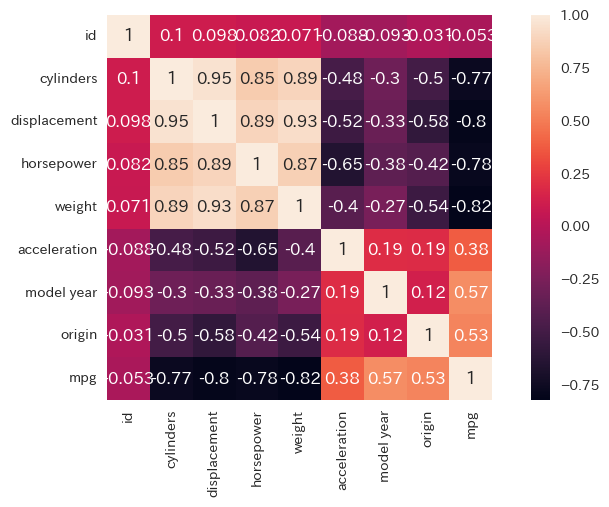

In [16]:
#trainデータの相関係数の可視化
plt.figure(figsize = (10,5))
sns.heatmap(train_df.corr(), square=True, annot=True)
plt.show()

mpgとの関係  
* 'origin','model year','accenlerarion'(加速度)は正の相関  
加速度は高いほど、燃費が良くなる  
* やはり、シリンダー数、'displacement'(排気量)、馬力、重量は負の相関  

その他  
* シリンダー、'displacement'(排気量)、馬力、重量はそれぞれかなり強い正の相関  

まとめ  
* cylinders,displacement,horsepower,weightとmpgの5つの変数の関連性が高い  
→5変数は車両の使用目的によっておおよそ決定する?

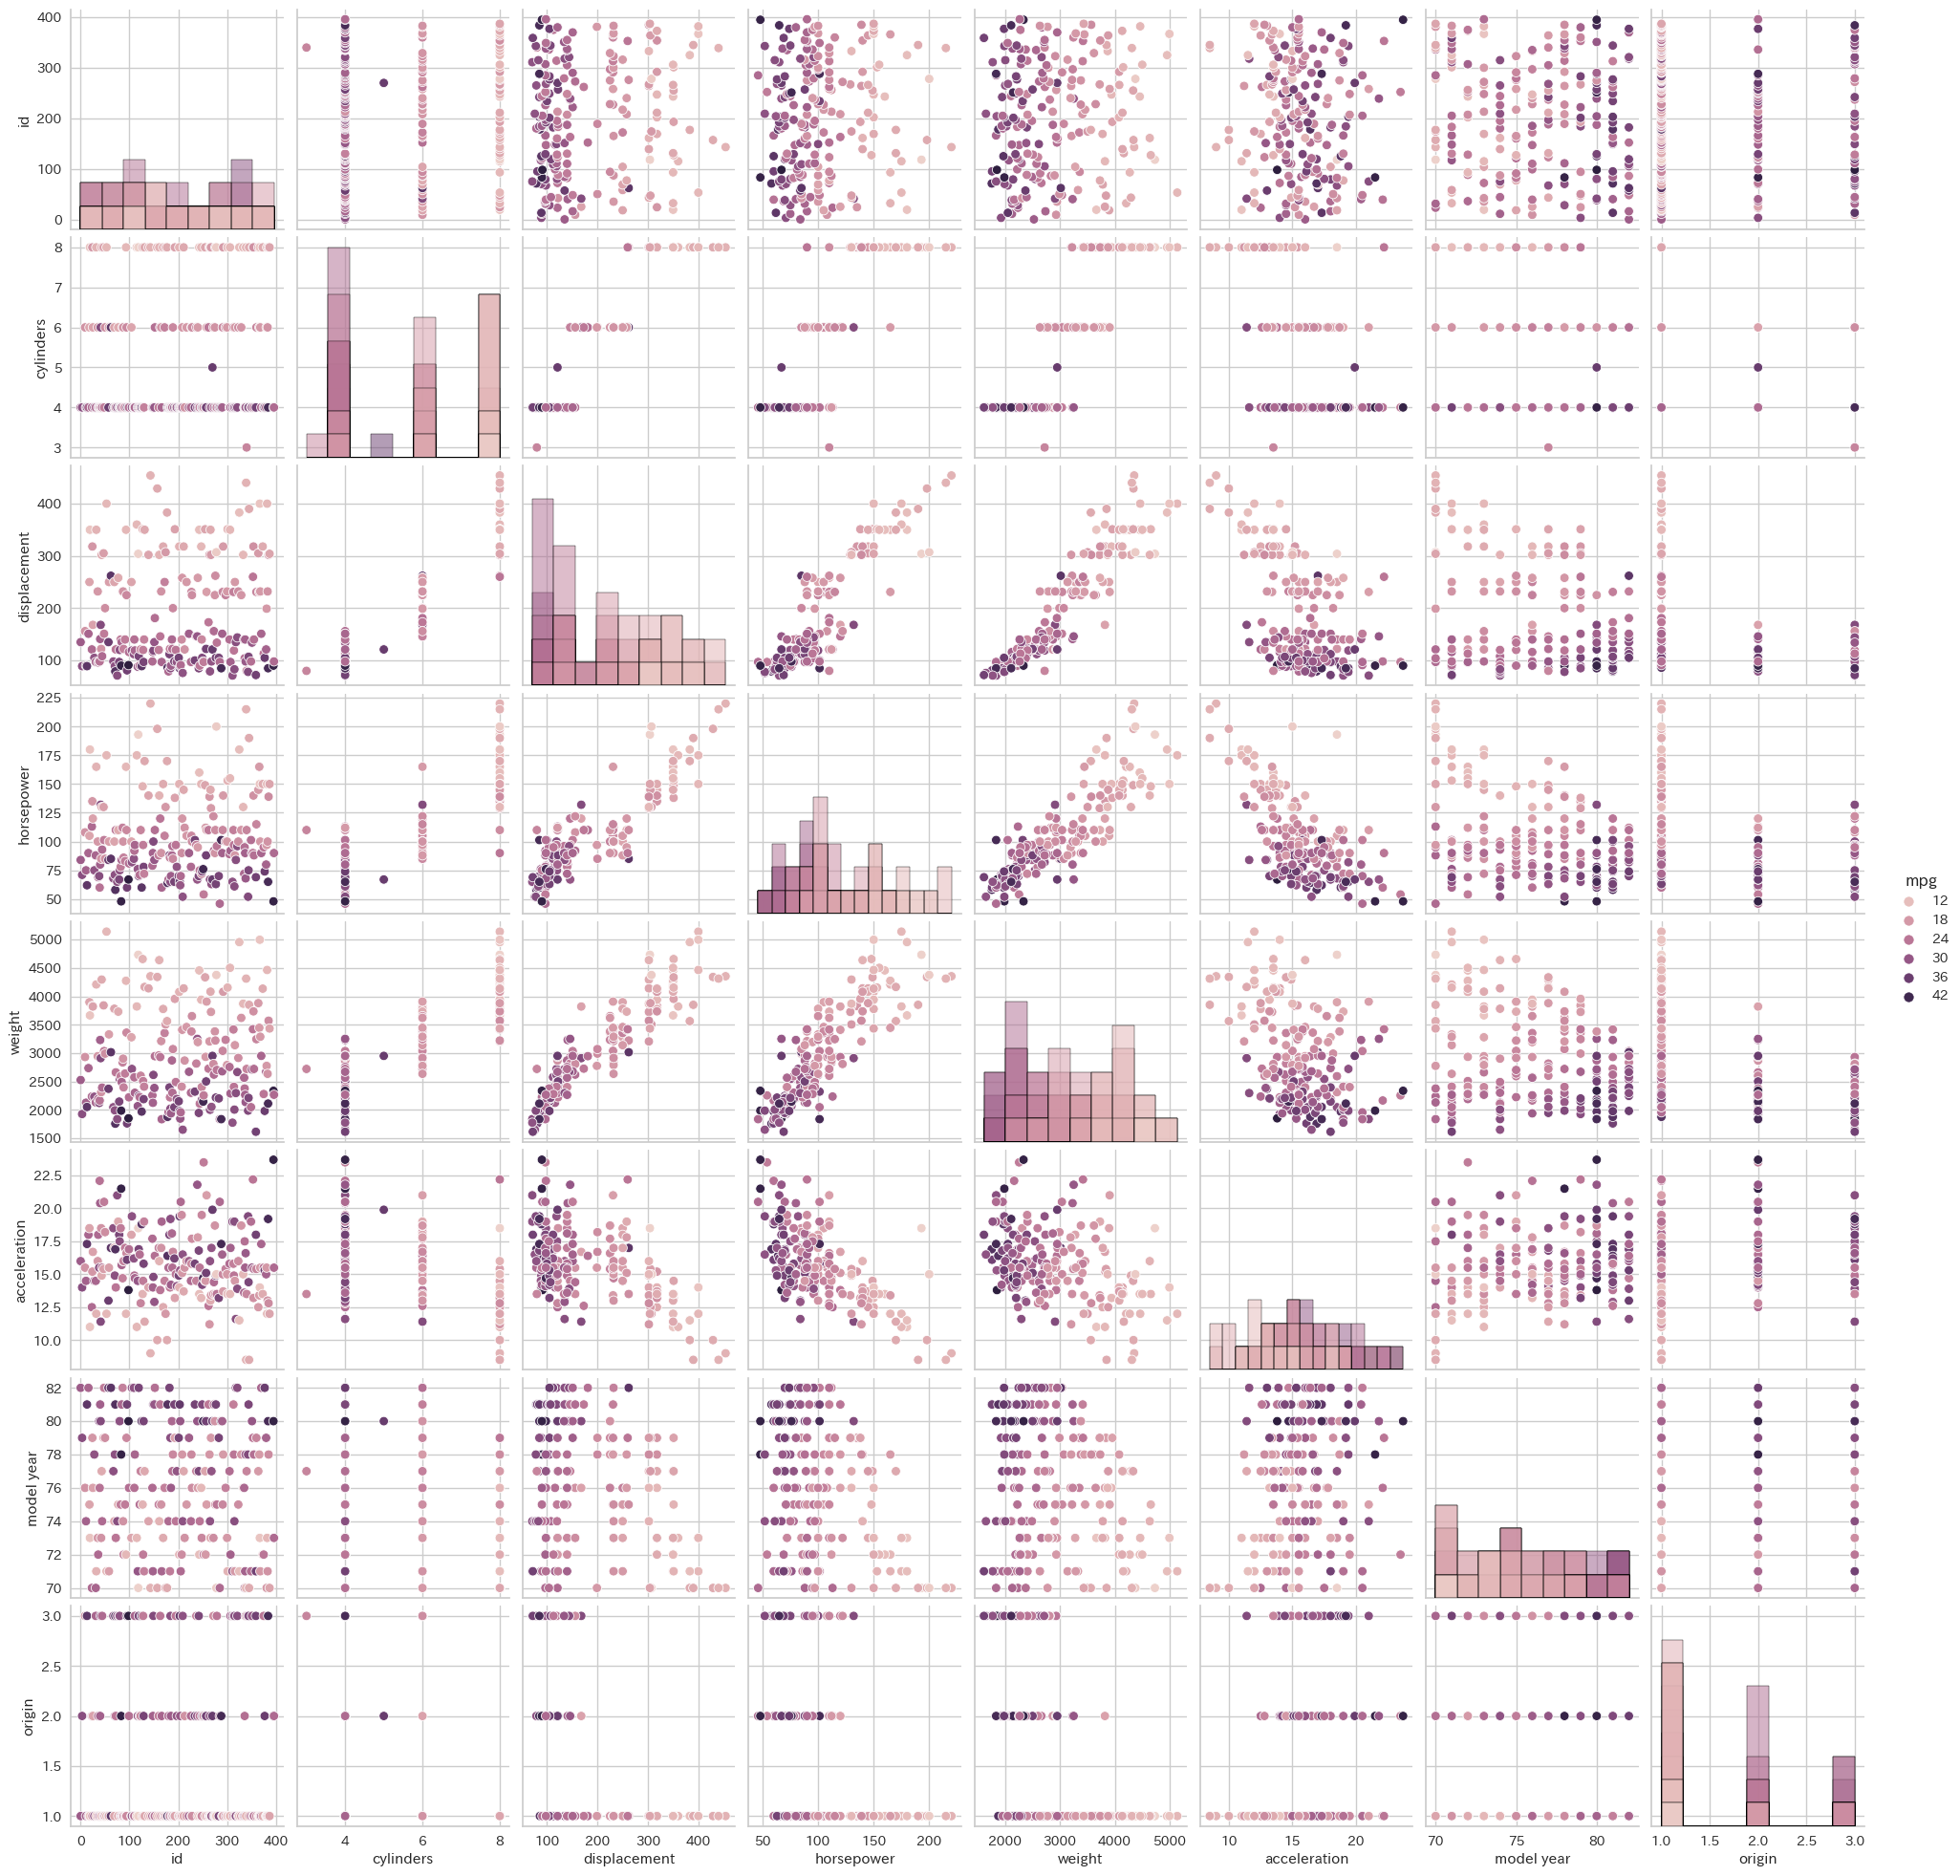

In [17]:
#散布図による可視化
sns.pairplot(train_df[:1000], hue='mpg', diag_kind ='hist')
plt.show()

<AxesSubplot:xlabel='displacement', ylabel='mpg'>

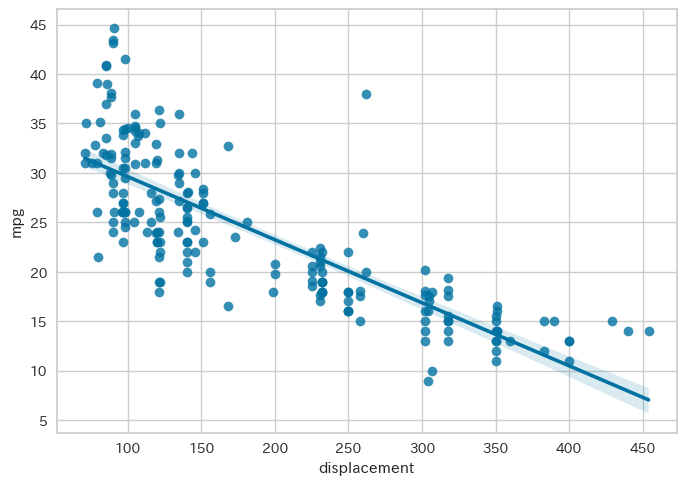

In [18]:
#2つの値の相関関係
# グラフの描画(mpgと'displacement')
sns.regplot(x='displacement', y='mpg', data=train_df,ci=90)

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

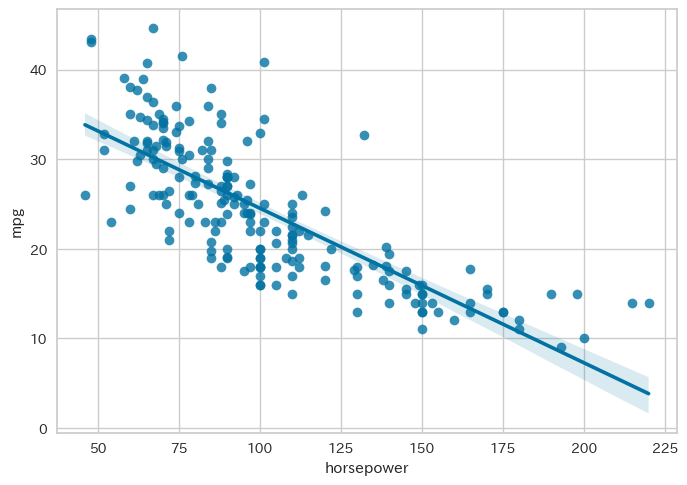

In [19]:
#2つの値の相関関係
# グラフの描画(mpgと'horsepower')
sns.regplot(x='horsepower', y='mpg', data=train_df,ci=90)

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

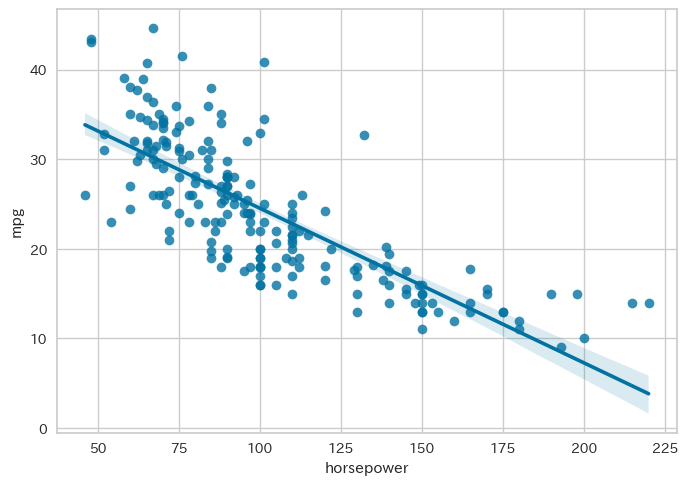

In [20]:
#2つの値の相関関係
# グラフの描画(mpgと'horsepower')
sns.regplot(x='horsepower', y='mpg', data=train_df,ci=90)

<AxesSubplot:xlabel='weight', ylabel='mpg'>

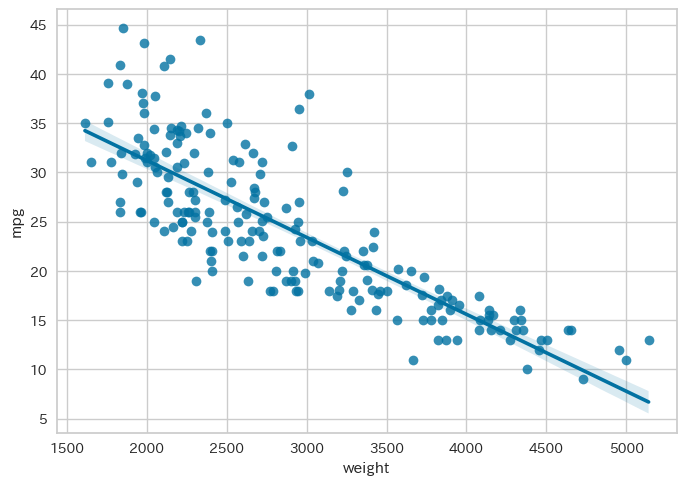

In [21]:
#2つの値の相関関係
# グラフの描画(mpgと'weight')
sns.regplot(x='weight', y='mpg', data=train_df,ci=90)

<AxesSubplot:xlabel='model year', ylabel='mpg'>

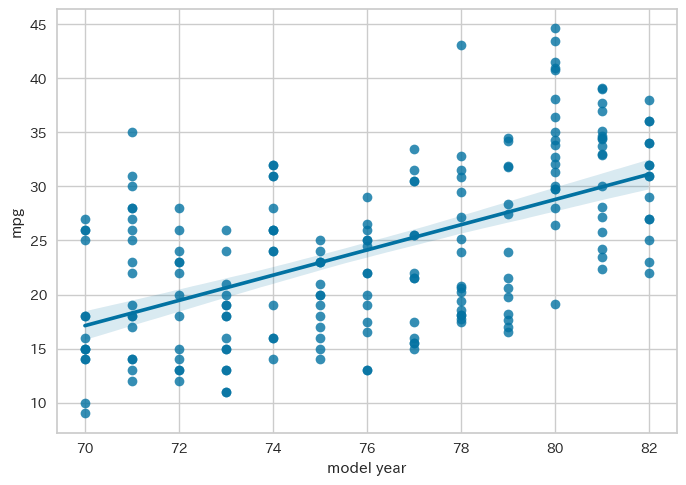

In [22]:
#2つの値の相関関係
# グラフの描画(mpgと'model year')
sns.regplot(x='model year', y='mpg', data=train_df,ci=90)

最新のモデルほど、走行距離は大きくなる傾向。

<AxesSubplot:xlabel='origin', ylabel='mpg'>

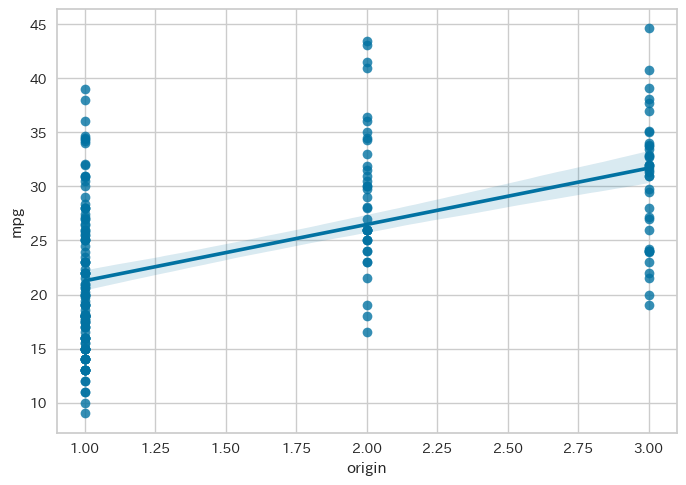

In [23]:
#2つの値の相関関係
# グラフの描画(mpgと'origin')
sns.regplot(x='origin', y='mpg', data=train_df,ci=90)

originは１(アメリカ)より2(ヨーロッパ),3(日本)の方が若干、走行距離が大きい傾向

In [24]:
#originの数値の割合を確認
train_df['origin'].value_counts()

1    122
3     39
2     38
Name: origin, dtype: int64

<AxesSubplot:xlabel='acceleration', ylabel='mpg'>

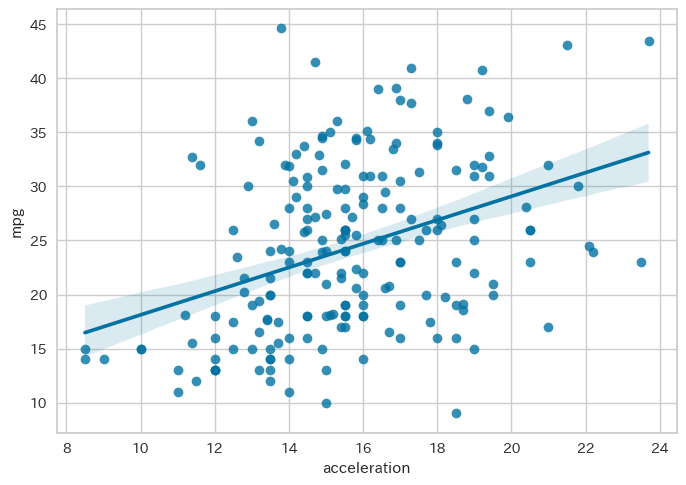

In [25]:
#2つの値の相関関係
# グラフの描画(mpgと'acceleration')
sns.regplot(x='acceleration', y='mpg', data=train_df,ci=90)

加速度と走行距離の相関は若干の正の相関だが、かなりばらつきがある。  
加速度は重さや排気量に負の相関

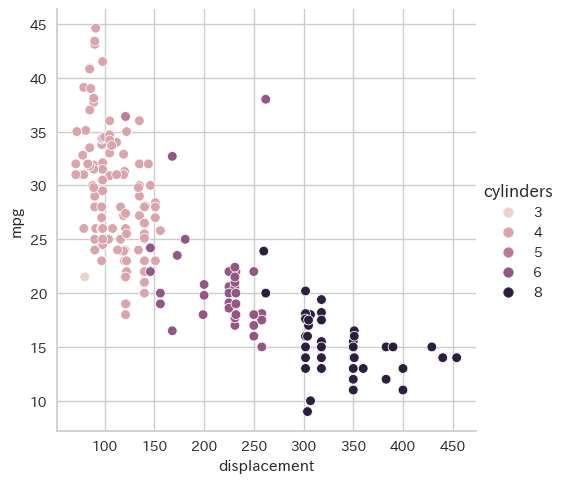

In [252]:
#相関が高い変数同士の比較 
#mpg、displacement、cylinderの関係性
sns.relplot(data=train_df,x='displacement',y='mpg', hue='cylinders')
plt.show()

排気量、シリンダー数に対してmpgは負の相関  
シリンダー数が大きいほど、排気量が大きくなり、走行距離も短くなる。とわかる。

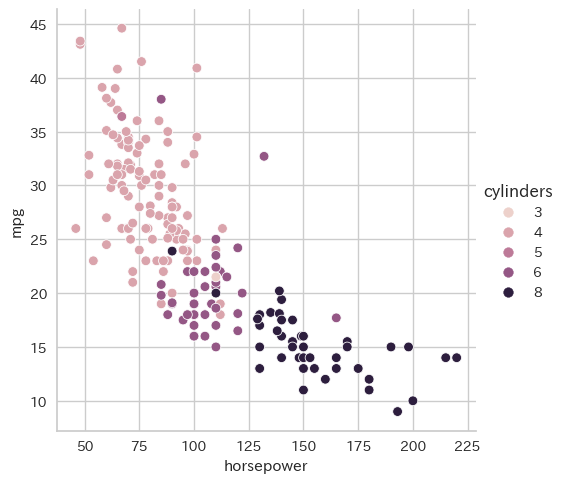

In [253]:
#相関が高い変数同士の比較 
#mpg、horsepower、cylinderの関係性
sns.relplot(data=train_df,x='horsepower',y='mpg', hue='cylinders')
plt.show()

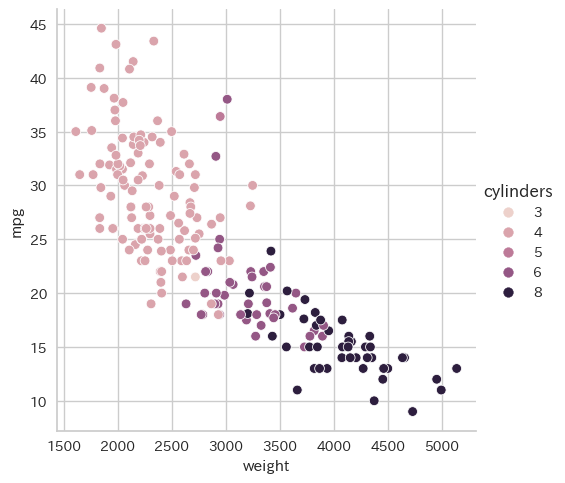

In [254]:
#相関が高い変数同士の比較 
#mpg、weight、cylinderの関係性
sns.relplot(data=train_df,x='weight',y='mpg', hue='cylinders')
plt.show()

上記２つの図より、馬力、重さにも排気量と同じ傾向に見える。  
* シリンダー8は重い、排気多い、馬力高い、の特徴?
* シリンダー4は軽い、排気少ない、馬力低い、の特徴?

#### 'model year'について 

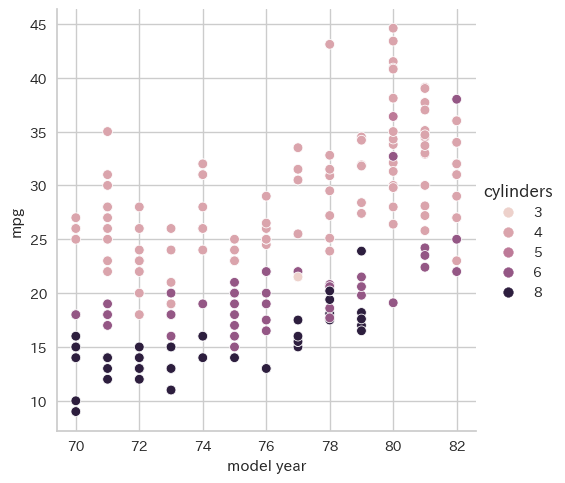

In [256]:
#相関が高い変数同士の比較 
#mpg、model year、cylinderの関係性
sns.relplot(data=train_df,x='model year',y='mpg', hue='cylinders')
plt.show()

model yearについては年代が最近になるにつれて、走行距離は伸びている。  
シリンダー数は大きいと走行距離は少なくなるには変わらないが、年代が最近になるごとに性能(燃費)が良くなっていると考えられる。

In [150]:
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year','car name':'car_name'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)



test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year','car name':'car_name'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [151]:
#教師なし学習なのでtrainデータから'mpg'を省く
df_train_cy_ye = df_train_cy_ye.drop(['mpg'],axis=1)
df_train_cy_ye.head(1)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se


In [152]:
def TablePlot(df,w,h,outputPath):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.table(
        df.values,
        colLabels = df.columns,
        loc = 'center',
        bbox=[0,0,1,1]
    )
    plt.savefig(outputPath)
    plt.show()

不要な列を削除

In [153]:
feature_names = ['displacement', 'horsepower', 'weight','acceleration']
df_train_km = df_train_cy_ye[feature_names]

標準化

In [154]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
km_train_ss = ss.fit_transform(df_train_km)

モデルで学習  
kmeansでグループ分けをする。

In [155]:
from sklearn.cluster import KMeans

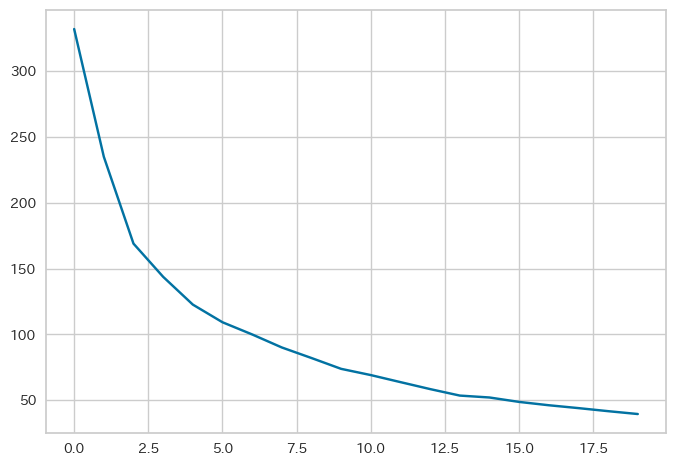

In [156]:
#エルボー図を表示
inertia = []
for i in range(2,22):
    KM = KMeans(n_clusters=i, random_state=0)
    KM.fit(km_train_ss)
    inertia.append(KM.inertia_)
    
plt.plot(inertia)
plt.show()

エルボー図でうまくクラスタ数を決めれそうにないので、  
ひとまず、クラスタ数を3つで考える。

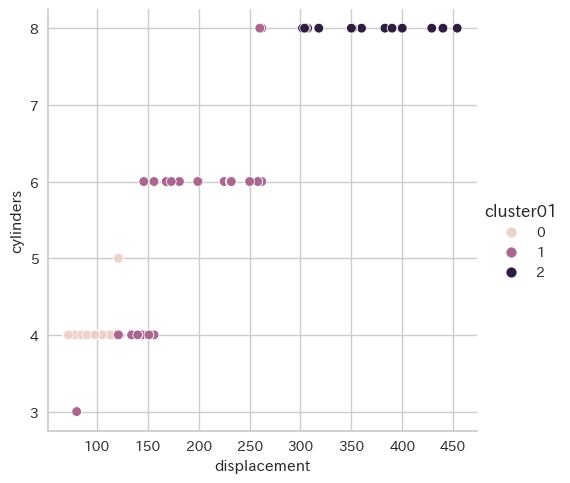

In [201]:
from sklearn.cluster import KMeans
# クラスタ分け
KM = KMeans(n_clusters=3, random_state=0)  #クラスタ数は3つ
KM.fit(km_train_ss)
cluster01 = KM.predict(km_train_ss)
# dfにクラスタを付け足す
df_train_km3 = copy.copy(df_train_cy_ye)
df_train_km3['cluster01'] = cluster01

# 散布図を出力
# displacement,cylindersとクラスター分け
sns.relplot(data=df_train_km3, x='displacement', y='cylinders', hue='cluster01')
plt.show()

In [202]:
cluster01 = pd.DataFrame(cluster01)
cluster01 = cluster01.rename(columns={0:'cluster01'})
cluster01.head()

,cluster01
0,0
1,0
2,1
3,0
4,0


In [159]:
cluster01 = cluster01.to_csv('cluster01.csv')

排気量の大きさで3つに分けているように見える。

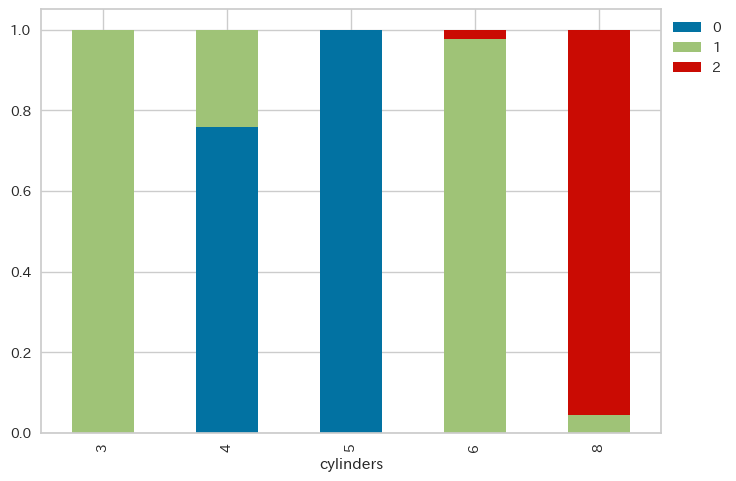

In [160]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
crosstable = pd.crosstab(df_train_km3.cylinders, df_train_km3.cluster01, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

量的データのクラスタはシリンダー数でもある程度説明できそう。

### test_dfのクラスターも作る。

不要な列を削除

In [161]:
feature_names = ['displacement', 'horsepower', 'weight','acceleration']
df_test_km = df_test_cy_ye[feature_names]

標準化

In [162]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
km_test_ss = ss.fit_transform(df_test_km)

モデルで学習  
kmeansでグループ分けをする。

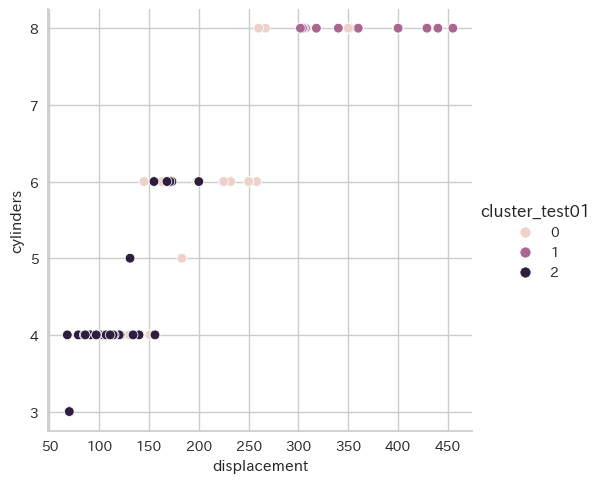

In [163]:
from sklearn.cluster import KMeans
# クラスタ分け
KM = KMeans(n_clusters=3, random_state=0)  #クラスタ数は3つ
KM.fit(km_test_ss)
cluster_test01 = KM.predict(km_test_ss)
# dfにクラスタを付け足す
df_test_km3 = copy.copy(df_test_cy_ye)
df_test_km3['cluster_test01'] = cluster_test01

# 散布図を出力
# displacement,mpgとクラスター分け
sns.relplot(data=df_test_km3, x='displacement', y='cylinders', hue='cluster_test01')
plt.show()

In [164]:
cluster_test01 = pd.DataFrame(cluster_test01)
cluster_test01 = cluster_test01.rename(columns={0:'cluster_test01'})
cluster_test01.head()

,cluster_test01
0,0
1,0
2,2
3,0
4,2


In [165]:
cluster_test01 = cluster_test01.to_csv('cluster_test01.csv')

排気量の大きさで3つに分けているように見える。

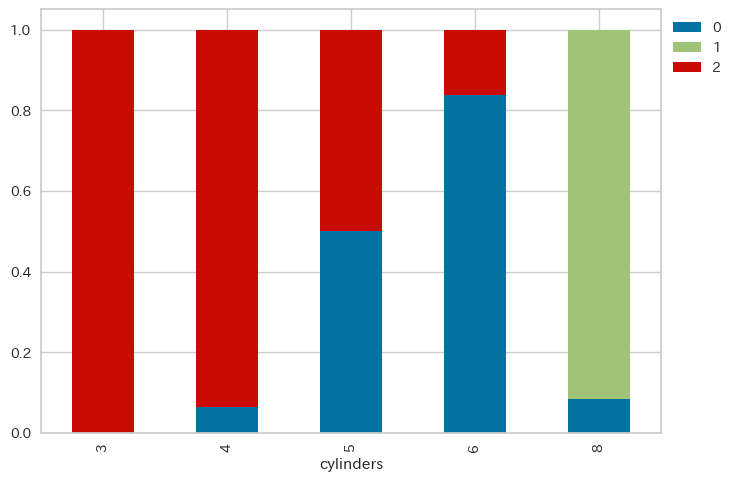

In [166]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
crosstable = pd.crosstab(df_test_km3.cylinders, df_test_km3.cluster_test01, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

量的データのクラスタはシリンダー数でもある程度説明できそう。

### カテゴリ変数が使える教師なし分類  
#### Gower距離行列に変換

In [167]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year','car name':'car_name'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)



test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year','car name':'car_name'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [168]:
#前処理
# 量的変数を標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df_train_ss = copy.copy(df_train_cy_ye)
quantity_features = ['displacement', 'horsepower', 'weight','acceleration']
df_train_ss[quantity_features] = ss.fit_transform(df_train_ss[quantity_features])
df_train_ss

# 質的変数をカテゴリ型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_train_ss[quality_features] = df_train_ss[quality_features].astype('category')

Grower距離に変換

In [169]:
# 質的変数をobject型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_train_ss[quality_features] = df_train_ss[quality_features].astype('object')

# Gower距離行列に変換
import gower

df_train_gw = copy.copy(df_train_ss)
df_train_gw .drop(['id','car_name'],axis=1)
df_train_gw = gower.gower_matrix(df_train_gw)
df_train_gw

array([[0.        , 0.35855487, 0.46441108, ..., 0.56836057, 0.5286808 ,
        0.432197  ],
       [0.35855487, 0.        , 0.51487184, ..., 0.69908446, 0.42021316,
        0.3485932 ],
       [0.46441108, 0.51487184, 0.        , ..., 0.6039495 , 0.6885464 ,
        0.5617332 ],
       ...,
       [0.56836057, 0.69908446, 0.6039495 , ..., 0.        , 0.70158684,
        0.57477355],
       [0.5286808 , 0.42021316, 0.6885464 , ..., 0.70158684, 0.        ,
        0.33128768],
       [0.432197  , 0.3485932 , 0.5617332 , ..., 0.57477355, 0.33128768,
        0.        ]], dtype=float32)

距離行列(df_train_gw)を使って、クラスタリングを試す。

#### Gower距離行列をkmeansする

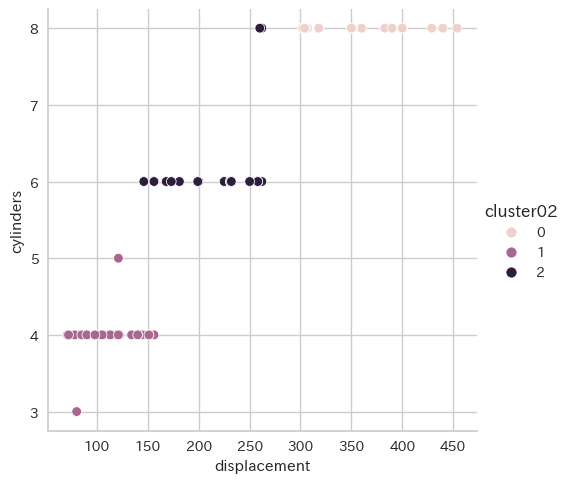

In [205]:
# Gower距離行列でkmeans
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=3,random_state=0)
KM.fit(df_train_gw)
cluster02 = KM.predict(df_train_gw)
df_train_cy_ye['cluster02'] = cluster02

# 散布図を出力
sns.relplot(data=df_train_cy_ye, x='displacement', y='cylinders', hue='cluster02')
plt.show()

In [206]:
cluster02 = pd.DataFrame(cluster02)
cluster02 = cluster02.rename(columns={0:'cluster02'})
cluster02.head()

,cluster02
0,1
1,1
2,2
3,1
4,1


In [172]:
cluster02 = cluster02.to_csv('cluster02.csv')

量的変数だけでkmeansしたときと、ほとんどかわらず。

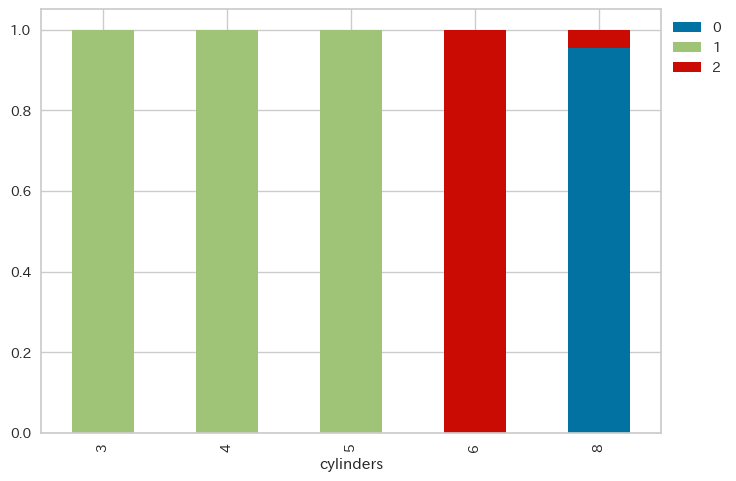

In [173]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
#cylindersとcluster
crosstable = pd.crosstab(df_train_cy_ye.cylinders, df_train_cy_ye.cluster02, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

車の性質はシリンダを確認すれば大体どのクラスタに分類できるかわかる。

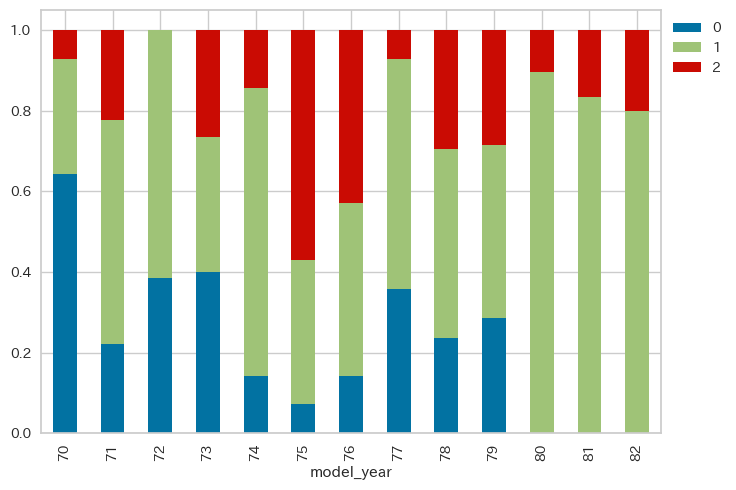

In [174]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
#model_yearとcluster
crosstable = pd.crosstab(df_train_cy_ye.model_year, df_train_cy_ye.cluster02, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

80年以降の車のモデルにはクラスタ0が存在していない。つまりシリンダ8の車は無いということになる。

### テストデータのクラスタもgraw変換してから作成

In [175]:
#前処理
# 量的変数を標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df_test_ss = copy.copy(df_test_cy_ye)
quantity_features = ['displacement', 'horsepower', 'weight','acceleration']
df_test_ss[quantity_features] = ss.fit_transform(df_test_ss[quantity_features])
df_test_ss

# 質的変数をカテゴリ型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_test_ss[quality_features] = df_test_ss[quality_features].astype('category')

Grower距離に変換

In [176]:
# 質的変数をobject型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_test_ss[quality_features] = df_test_ss[quality_features].astype('object')

# Gower距離行列に変換
import gower

df_test_gw = copy.copy(df_test_ss)
df_test_gw .drop(['id','car_name'],axis=1)
df_test_gw = gower.gower_matrix(df_test_gw)
df_test_gw

array([[0.        , 0.35447386, 0.46654904, ..., 0.57035476, 0.70582706,
        0.4824915 ],
       [0.35447386, 0.        , 0.4959837 , ..., 0.41283292, 0.4513532 ,
        0.52714354],
       [0.46654904, 0.4959837 , 0.        , ..., 0.41684923, 0.69870776,
        0.43115982],
       ...,
       [0.57035476, 0.41283292, 0.41684923, ..., 0.        , 0.41671136,
        0.2143106 ],
       [0.70582706, 0.4513532 , 0.69870776, ..., 0.41671136, 0.        ,
        0.5269455 ],
       [0.4824915 , 0.52714354, 0.43115982, ..., 0.2143106 , 0.5269455 ,
        0.        ]], dtype=float32)

距離行列(df_train_gw)を使って、クラスタリングを試す。

#### Gower距離行列をkmeansする

In [177]:
# Gower距離行列でkmeans
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=3,random_state=0)
KM.fit(df_test_gw)
cluster_test02 = KM.predict(df_test_gw)
df_test_cy_ye['cluster_test02'] = cluster_test02

# 散布図を出力
#sns.relplot(data=df_train_cy_ye, x='displacement', y='cylinders', hue='cluster_test02')
#plt.show()

In [178]:
cluster_test02 = pd.DataFrame(cluster_test02)
cluster_test02 = cluster_test02.rename(columns={0:'cluster_test02'})
cluster_test02.head()

,cluster_test02
0,0
1,2
2,0
3,2
4,0


In [179]:
cluster_test02 = cluster_test02.to_csv('cluster_test02.csv')

量的変数だけでkmeansしたときと、ほとんどかわらず。

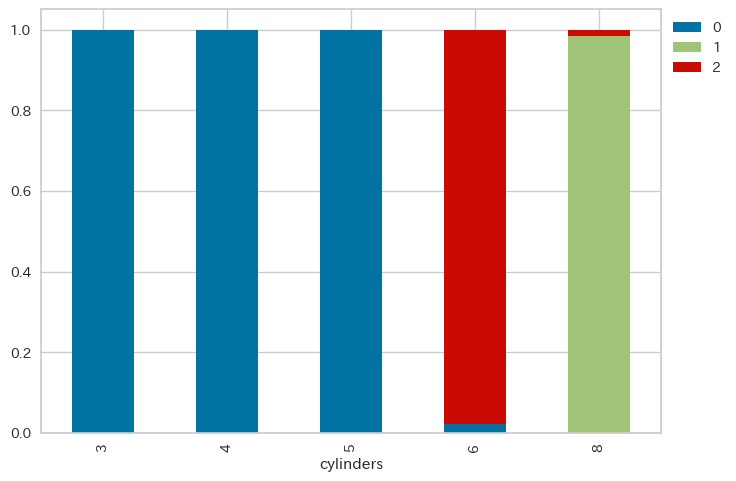

In [180]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
#cylindersとcluster
crosstable = pd.crosstab(df_test_cy_ye.cylinders, df_test_cy_ye.cluster_test02, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### ward法  
ward法を使って、クラスタ間の距離を調べる。

In [181]:
# fclusterは後で使います。
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

距離行列のいらない重複部分を削って、1次元に変換する。

In [182]:
from scipy.spatial.distance import squareform
# 距離行列を凝縮距離行列に変換
df_train_gw_1d = squareform(df_train_gw)
print(df_train_gw_1d)

[0.35855487 0.46441108 0.24371803 ... 0.70158684 0.57477355 0.33128768]


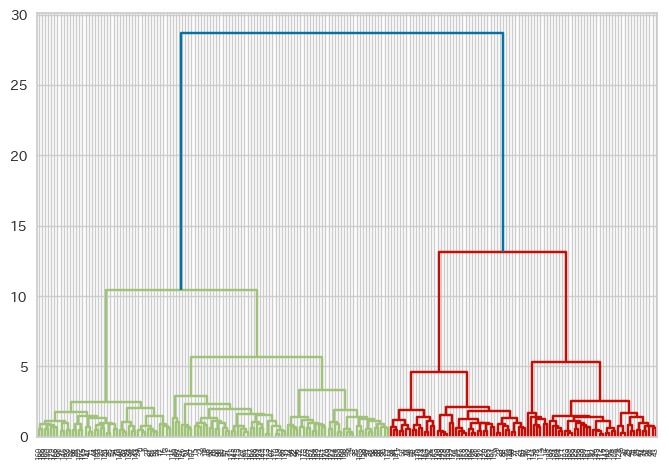

In [183]:
# デンドログラムの作成
result = linkage(df_train_gw, method='ward')
dendrogram(result)
plt.show()

緑と赤で、距離があるので比較的性質が異なるものだとわかる。

#### ward法でクラスター分け

In [207]:
# fclusterでクラスタ分け。tはデンドログラムの縦軸と同じ。
result = linkage(df_train_gw_1d, method='ward')
cluster04 = fcluster(result, t=2.5, criterion='distance')
df_train_cy_ye['cluster04'] = cluster04
cluster04

array([1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
       1], dtype=int32)

各データ店が２つに分かれる。

#### 散布図、グラフでkmeansとの違いを比べる。

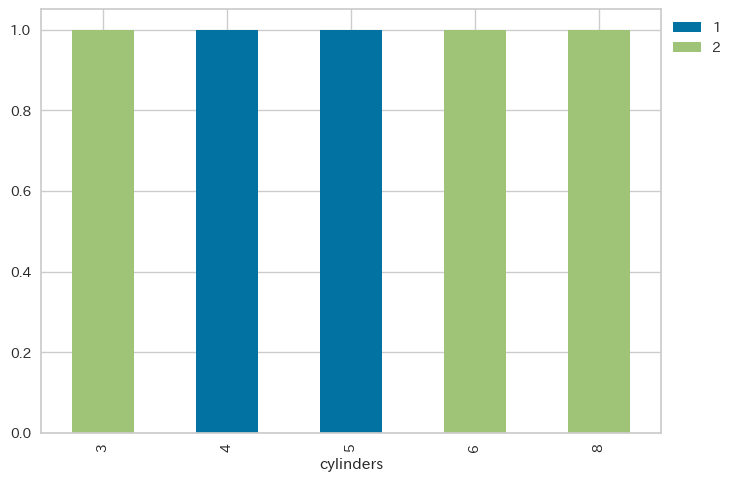

In [185]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
crosstable = pd.crosstab(df_train_cy_ye.cylinders, df_train_cy_ye.cluster04, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [186]:
cluster04 = pd.DataFrame(cluster04)
cluster04 = cluster04.rename(columns={0:'cluster04'})
cluster04.head()

,cluster04
0,1
1,1
2,2
3,1
4,1


In [187]:
cluster04 = cluster04.to_csv('cluster04.csv')

### testデータでもward法でクラスタを作る。

In [188]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year','car name':'car_name'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)



test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year','car name':'car_name'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name','mpg'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [189]:
#前処理
# 量的変数を標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df_test_ss = copy.copy(df_test_cy_ye)
quantity_features = ['displacement', 'horsepower', 'weight','acceleration']
df_test_ss[quantity_features] = ss.fit_transform(df_test_ss[quantity_features])
df_test_ss

# 質的変数をカテゴリ型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_test_ss[quality_features] = df_test_ss[quality_features].astype('category')

In [190]:
# 質的変数をobject型に変換
quality_features = ['cylinders', 'model_year', 'origin', 'car_name']
df_test_ss[quality_features] = df_test_ss[quality_features].astype('object')

# Gower距離行列に変換
import gower

df_test_gw = copy.copy(df_test_ss)
df_test_gw .drop(['id','car_name'],axis=1)
df_test_gw = gower.gower_matrix(df_test_gw)
df_test_gw

array([[0.        , 0.35447386, 0.46654904, ..., 0.57035476, 0.70582706,
        0.4824915 ],
       [0.35447386, 0.        , 0.4959837 , ..., 0.41283292, 0.4513532 ,
        0.52714354],
       [0.46654904, 0.4959837 , 0.        , ..., 0.41684923, 0.69870776,
        0.43115982],
       ...,
       [0.57035476, 0.41283292, 0.41684923, ..., 0.        , 0.41671136,
        0.2143106 ],
       [0.70582706, 0.4513532 , 0.69870776, ..., 0.41671136, 0.        ,
        0.5269455 ],
       [0.4824915 , 0.52714354, 0.43115982, ..., 0.2143106 , 0.5269455 ,
        0.        ]], dtype=float32)

In [191]:
from scipy.spatial.distance import squareform
# 距離行列を凝縮距離行列に変換
df_test_gw_1d = squareform(df_test_gw)
print(df_test_gw_1d)

[0.35447386 0.46654904 0.39126864 ... 0.41671136 0.2143106  0.5269455 ]


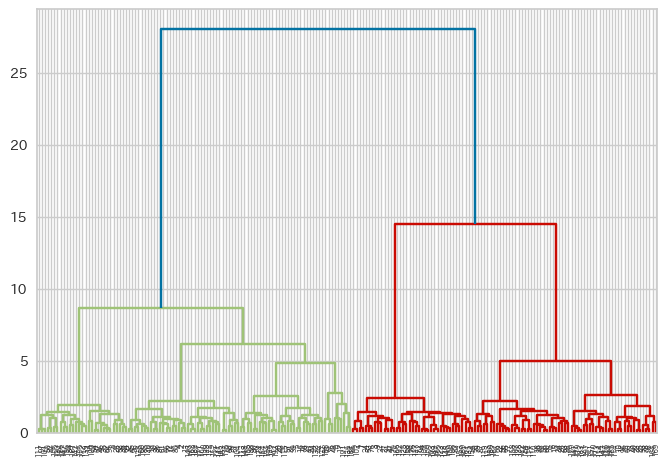

In [192]:
# デンドログラムの作成
result = linkage(df_test_gw, method='ward')
dendrogram(result)
plt.show()

緑と赤で、距離があるので比較的性質が異なるものだとわかる。

#### ward法でクラスター分け

In [193]:
# fclusterでクラスタ分け。tはデンドログラムの縦軸と同じ。
result = linkage(df_test_gw_1d, method='ward')
cluster_test04 = fcluster(result, t=2.6, criterion='distance')
df_test_cy_ye['cluster_test04'] = cluster_test04
cluster_test04

array([1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2,
       1], dtype=int32)

In [194]:
cluster_test04 = pd.DataFrame(cluster_test04)
cluster_test04 = cluster_test04.rename(columns={0:'cluster_test04'})
cluster_test04.head()

,cluster_test04
0,1
1,2
2,1
3,2
4,1


In [195]:
cluster_test04 = cluster_test04.to_csv('cluster_test04.csv')

各データ店が２つに分かれる。

#### 散布図、グラフでkmeansとの違いを比べる。

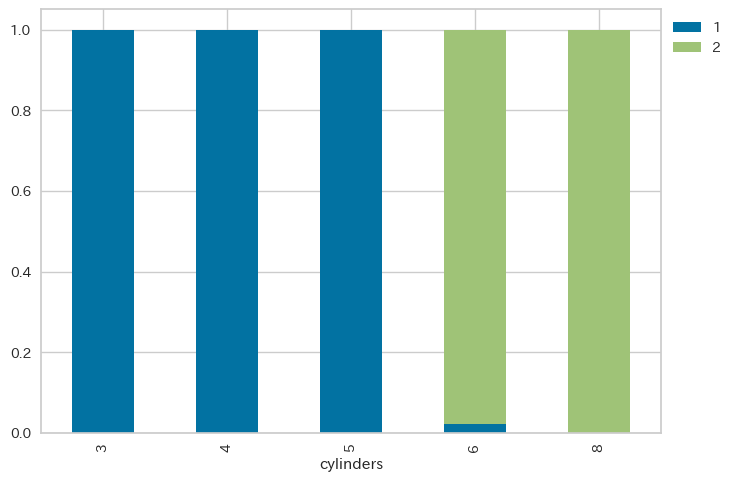

In [196]:
#上のクラスタとシリンダーの関係を確認
#積み上げ棒グラフ
crosstable = pd.crosstab(df_test_cy_ye.cylinders, df_test_cy_ye.cluster_test04, normalize='index')
crosstable.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# 検証1  
### 重回帰モデル

In [65]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

#df_train_cy_ye['cluster01'] = cluster01['cluster01']
df_train_cy_ye['cluster02'] = cluster02['cluster02']
#df_train_cy_ye['cluster04'] = cluster04['cluster04']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

#df_test_cy_ye['cluster01'] = cluster_test01['cluster_test01']
df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']
#df_test_cy_ye['cluster04'] = cluster_test04['cluster_test04']

早速重回帰モデルの作成

In [46]:
from sklearn.linear_model import LinearRegression as LR

In [47]:
# データの準備
y_train = df_train_cy_ye[["mpg"]] # 被説明変数
X_train = df_train_cy_ye[["weight", "displacement"]] # 説明変数

# モデルの生成
lr = LR()

# モデルの学習
lr.fit(X_train, y_train)

LinearRegression()

### 学習結果

In [48]:
print(lr.coef_) # 傾き
print(lr.intercept_) # 切片
print(lr.score(X_train, y_train)) # 決定係数

[[-0.00513703 -0.02383218]]
[43.4901176]
0.6851901992035567


y = b1 × -0.00513703 + b2 × -0.02383218 + 43.4901176

In [52]:
# テストデータを予測する
y_pred_train = lr.predict(X_train)
#y_pred_train


In [55]:
df_train_cy_ye['pred'] = y_pred_train

# 実データと予測結果の差をresとして代入
df_train_cy_ye['res'] = df_train_cy_ye['mpg'] - df_train_cy_ye['pred']

# ソート
print(df_train_cy_ye.sort_values(by='res'))

model yearが古い時にマイナス、新しい時にプラスにずれている

## 特徴量の追加  
### 説明変数にmodel yearを追加

In [57]:
y_train = df_train_cy_ye[["mpg"]]
X_train = df_train_cy_ye[["weight", "displacement", "model_year"]]


lr = LR()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)

print(lr.score(X_train, y_train)) # 決定係数

0.806202914350324


model yearを説明変数に設定したところ決定変数の値が約0.2上昇

## 再検証

In [58]:
# テストデータを予測する
y_pred_train = lr.predict(X_train)
#y_pred_train


In [61]:
df_train_cy_ye['pred'] = y_pred_train
df_train_cy_ye['res'] = df_train_cy_ye['mpg'] - df_train_cy_ye['pred']
#print(df_train_cy_ye.sort_values(by='res'))

通常年式だけではなく、車の種類とセットのため、car nameもセットで関係していると予測

## ダミー変数化
ダミー変数化できるカラムを自動で認識

In [68]:
X_train = pd.get_dummies(
    df_train_cy_ye[["weight", "displacement", "model_year", "car name"]]) 
#print(X_train)

## 再度モデルの作成と検証

In [73]:
y_train = df_train_cy_ye[["mpg"]]
X_train = pd.get_dummies(
    df_train_cy_ye[["weight", "displacement", "model_year", "car name"]]) 

lr = LR()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)

df_train_cy_ye['pred'] = y_pred_train
df_train_cy_ye['res'] = df_train_cy_ye['mpg'] - df_train_cy_ye['pred']
#print(df_train_cy_ye.sort_values(by='res'))

print(lr.score(X_train, y_train))

0.9834170393004322


予測データと実データの差が減少  
car nameのダミー変数化前に比べて決定係数が約0.3上昇

car nameをダミー変数化することで決定係数が大幅に改善  
だが、過学習の可能性

## 再検証  
全ての特徴量とcluster02を入れる。

In [79]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

#df_train_cy_ye['cluster01'] = cluster01['cluster01']
df_train_cy_ye['cluster02'] = cluster02['cluster02']
#df_train_cy_ye['cluster04'] = cluster04['cluster04']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

#df_test_cy_ye['cluster01'] = cluster_test01['cluster_test01']
df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']
#df_test_cy_ye['cluster04'] = cluster_test04['cluster_test04']

## 特徴量の追加  

In [80]:
# 説明変数とmpgを取り出し
x = df_train_cy_ye.drop('mpg', axis=1)
y = df_train_cy_ye['mpg']


In [83]:
y_train = df_train_cy_ye[["mpg"]]
X_train = df_train_cy_ye[['cylinders','displacement','horsepower','weight','acceleration','model_year','origin']]

# データをトレーニング用と検証用に分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


lr = LR()
lr.fit(x, y)
y_pred_train = lr.predict(x)

print(lr.score(x_train, y_train)) # 決定係数

0.8311996977807597


model yearを説明変数に設定したところ決定変数の値が約0.03上昇

## 再検証

In [97]:
#訓練データを予測
pred_train = lr.predict(x_train)

In [98]:
# テストデータを予測する
pred_test = lr.predict(x_test)
#y_pred_train


In [90]:
df_train_cy_ye.shape

(199, 10)

In [91]:
x_test.shape

(40, 9)

In [96]:
pred_train

array([33.03734452, 35.65101813, 37.35677114, 10.09210809, 20.67647033,
       11.63582122, 30.6828597 , 24.84018823,  7.70073608, 27.86106664,
       31.09368716, 25.35467096, 27.91484227, 12.82748952, 35.83009821,
       15.72695348, 11.1899755 , 26.57253493, 23.6004473 , 23.92199848,
       15.66497337, 28.50509556, 24.65106535, 22.60053725, 15.24118686,
       33.08376419, 29.70095763, 35.58455581, 30.69874495, 26.73343236,
       16.34529073, 15.38294395, 15.03417125,  9.32467198, 28.5017467 ,
       33.54962367, 16.78504851, 35.59307982, 15.88405183, 13.22168004])

In [101]:
print('検証用：',np.sqrt(mean_squared_error(y_test,pred_test)))

検証用： 3.473681639249747


精度はそれほど良くはない、、

# 検証2  
### RandomForest

In [2]:
import pandas as pd
import numpy as np

import pycaret

#setup関数をimport
from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
from pycaret.regression import finalize_model

from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

cluster02を取り入れて前処理  
変数が多すぎるのでcar_nameを除く

In [18]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

#df_train_cy_ye['cluster01'] = cluster01['cluster01']
df_train_cy_ye['cluster02'] = cluster02['cluster02']
#df_train_cy_ye['cluster04'] = cluster04['cluster04']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

#df_test_cy_ye['cluster01'] = cluster_test01['cluster_test01']
df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']
#df_test_cy_ye['cluster04'] = cluster_test04['cluster_test04']

In [19]:
df_train_cy_ye.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,cluster02
0,0,4,135.0,84.0,2525.0,16.0,82,1,29.0,4
1,3,4,89.0,71.0,1925.0,14.0,79,2,31.9,4
2,9,6,156.0,108.0,2930.0,15.5,76,3,19.0,5
3,11,4,90.0,75.0,2125.0,14.5,74,1,28.0,4
4,13,4,89.0,62.0,2050.0,17.3,81,3,37.7,4


In [20]:
df_test_cy_ye.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,cluster02
0,1,6,145.0,76.0,3160.0,19.6,81,2,4
1,2,6,250.0,98.0,3525.0,19.0,77,1,5
2,4,4,119.0,92.0,2434.0,15.0,80,3,4
3,5,6,258.0,110.0,2962.0,13.5,71,1,5
4,6,4,97.0,88.0,2100.0,16.5,72,3,4


In [21]:
df_train_cy_ye.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
mpg             float64
cluster02         int64
dtype: object

In [22]:
# ランダムフォレスト回帰をインポート
from sklearn.ensemble import RandomForestRegressor
# 絶対平均誤差のインポート
from sklearn.metrics import mean_absolute_error

# 説明変数とmpgを取り出し
x = df_train_cy_ye.drop('mpg', axis=1)
y = df_train_cy_ye['mpg']

# データをトレーニング用と検証用に分割
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
# ランダムフォレスト回帰インスタンス
forest = RandomForestRegressor()
# ランダムフォレストで学習
forest.fit(train_x, train_y)

RandomForestRegressor()

In [26]:
# パラメータの寄与度を表示
importance = pd.DataFrame(forest.feature_importances_, index=train_x.columns, columns=['importance'])
importance.sort_values(by='importance',ascending=False)

,importance
displacement,0.422528
horsepower,0.186503
weight,0.180907
model_year,0.135375
acceleration,0.026349
cylinders,0.025803
id,0.015149
origin,0.006656
cluster02,0.000731


In [27]:
# テストデータを予測する
predicteds = forest.predict(test_x)
predicteds
# 精度検証
mean_absolute_error(test_y, predicteds)

2.3521750000000003

折れ線グラフでサンプルごとの予測・正解の値がどれだけずれているのか可視化

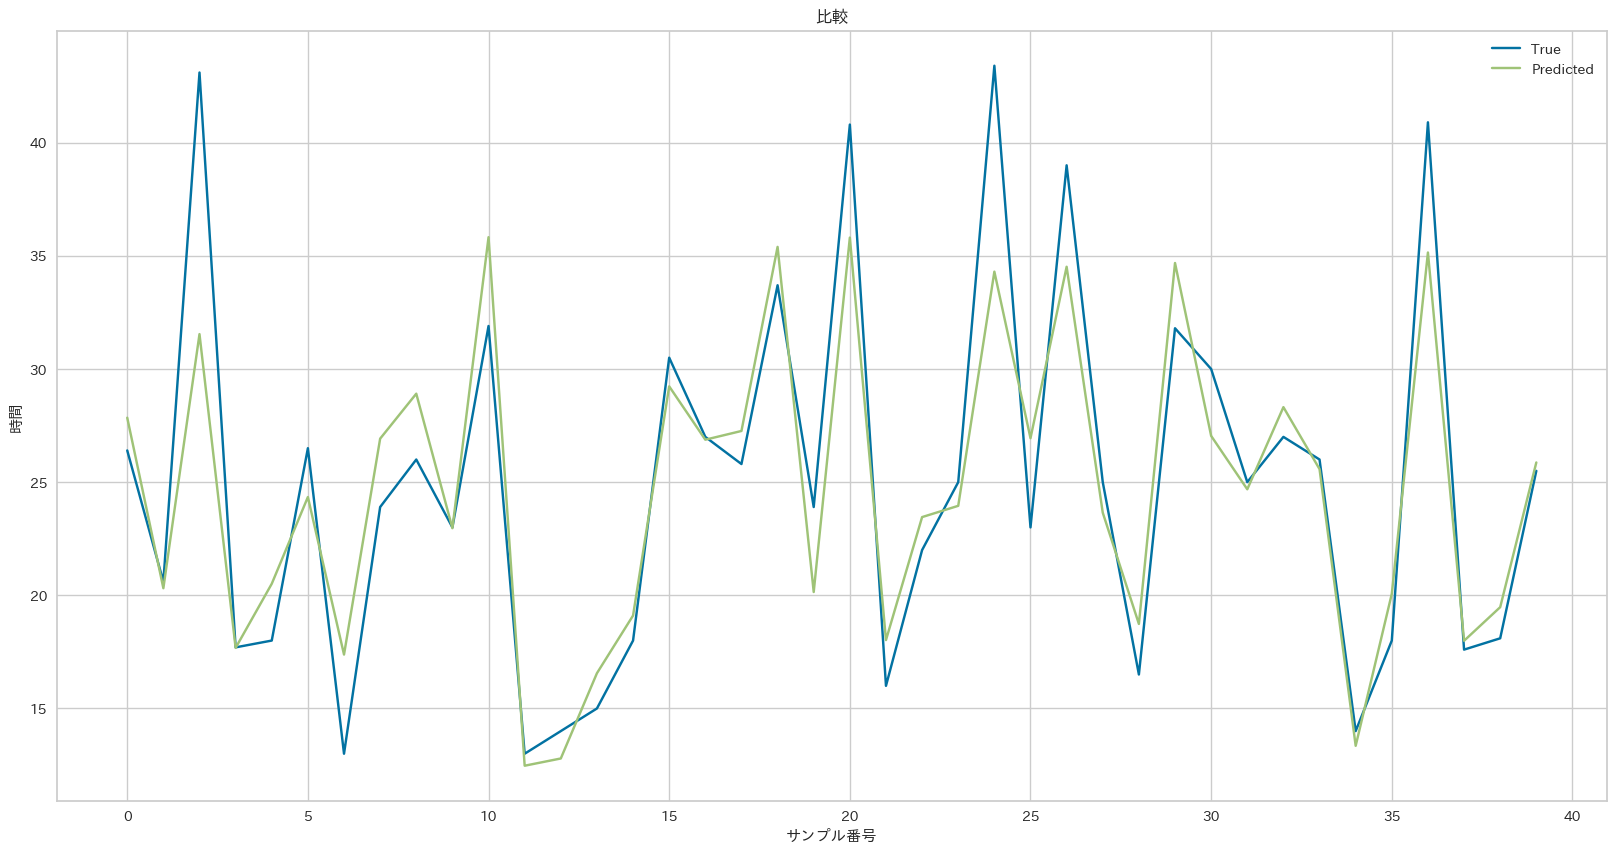

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.plot(test_y.values,label="True")
plt.plot(predicteds, label="Predicted")
plt.legend()
plt.title('比較')
plt.xlabel('サンプル番号')
plt.ylabel('時間')
plt.show()

### ハイパーパラメータのチューニング  
GridSearchCVクラスを利用して、ハイパーパラメータの組み合わせを実行して精度高く学習できた機械学習モデルを取り出す

In [29]:
# GridSearchCVをインポート
from sklearn.model_selection import GridSearchCV
# 試したいハイパーパラメータを各々に配列で用意
params = {
    'n_estimators'  : [4, 8, 16, 32],
    'max_depth' : [8, 16, 32, 64],
    'n_jobs': [-1]
}

GridSearchCVクラスでfitをコールしトレーニング

In [30]:
# GridSearchCVにランダムフォレストと試行パラメータを
# 渡してインスタンス作成
cv = GridSearchCV(
    RandomForestRegressor(),
    params,
    verbose=2
)
# トレーニング
cv.fit(train_x, train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=8, n_estimators=4, n_jobs=-1 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... max_depth=8, n_estimators=4, n_jobs=-1, total=   7.0s
[CV] max_depth=8, n_estimators=4, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=4, n_jobs=-1, total=   0.2s
[CV] max_depth=8, n_estimators=4, n_jobs=-1 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] ........... max_depth=8, n_estimators=4, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=4, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=4, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=4, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=4, n_jobs=-1, total=   0.0s
[CV] max_depth=8, n_estimators=8, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=8, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=8, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=8, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=8, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=8, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=8, n_jobs=-1 ..........................
[CV] ........... max_depth=8, n_estimators=8, n_jobs=-1, total=   0.1s
[CV] max_depth=8, n_estimators=8, n_jobs=-1 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   12.3s finished


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [8, 16, 32, 64],
                         'n_estimators': [4, 8, 16, 32], 'n_jobs': [-1]},
             verbose=2)

トレーニングが完了したモデルインスタンスがGridSearchCVクラスに格納されているので取り出して利用

In [33]:
from sklearn.metrics import mean_squared_error


In [34]:
# もっとも精度が良かったモデルを取り出して予測
forest = cv.best_estimator_
preds = forest.predict(test_x)
# 精度検証
mean_squared_error(test_y, preds)

11.642085937499994

一旦提出

In [35]:
# 目的変数と説明変数の生成
#test_df = test_df.drop('mpg', axis=1)
df_test_cy_ye.shape

(199, 9)

ランダムフォレストの場合

In [36]:
test_pred = pred_test=forest.predict(df_test_cy_ye)
print(len(test_pred))

199


In [37]:
test_pred[:50]

array([28.375  , 19.01875, 32.14375, 17.76875, 27.375  , 22.5625 ,
       14.1375 , 19.80625, 24.25   , 20.4125 , 11.5625 , 29.3    ,
       12.75   , 33.9    , 34.0125 , 14.075  , 21.875  , 24.25625,
       14.78125, 31.13125, 25.90625, 35.775  , 15.5125 , 12.625  ,
       13.46875, 12.8125 , 13.53125, 19.575  , 28.35625, 27.925  ,
       33.1125 , 19.075  , 36.39375, 11.5625 , 19.575  , 31.35   ,
       31.35   , 19.975  , 29.50625, 35.75625, 11.875  , 29.525  ,
       21.4375 , 29.38125, 21.25   , 35.5    , 36.98125, 19.775  ,
       25.4625 , 25.5    ])

In [40]:
sub = test_df.copy()
sub['mpg'] = test_pred
sub.head(5)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,1,6,145.0,76.00,3160.0,19.6,81,2,28.37500
1,2,6,250.0,98.00,3525.0,19.0,77,1,19.01875
2,4,4,119.0,92.00,2434.0,15.0,80,3,32.14375
3,5,6,258.0,110.0,2962.0,13.5,71,1,17.76875
4,6,4,97.0,88.00,2100.0,16.5,72,3,27.37500


In [41]:
# 提出ファイル
sub[['id','mpg']].to_csv('sample_submit_07.csv', index=False, header = False)

In [42]:
sample_submit_07 = pd.read_csv('sample_submit_07.csv')
sample_submit_07.head(5)

,1,28.375000000000004
0,2,19.01875
1,4,32.14375
2,5,17.76875
3,6,27.37500
4,7,22.56250


テストデータ提出  
評価(RMSE):2.9285634  
まずまずの精度

### 検証3  
まずは特徴量はcar nameの変数が多すぎるので除いてAutoMLにかけてみる

前処理

In [236]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})

#car nameを除く
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name','mpg'])

#testデータの読み込み
test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [237]:
df_train_cy_ye[train_df['horsepower']=='?'][['cylinders','origin','horsepower']]

,cylinders,origin,horsepower
24,4,1,84.272727
113,4,2,73.285714
145,4,2,72.733333
175,4,1,75.333333


In [238]:

clf = setup(data=df_train_cy_ye, 
            target="mpg",  #正解データを指定
            session_id=123  # 環境の初期化
           )

,Description,Value
0,session_id,123
1,Target,mpg
2,Original Data,"(199, 9)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(139, 25)"


In [239]:
#全てのモデルを訓練し、評価する。
best_model = compare_models()

今回signateの評価方法は「RMSE」(小さいほど良い)なので注目

In [306]:
#最もスコアの良いモデルの概要を表示する。
print(best_model)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


### モデル作成

In [307]:
#models関数により、すべての使用可能な機械学習モデルを確認
#機械学習モデルの一覧
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


最も精度の良かったBayesianRidgeでモデルを作成する。

In [308]:
#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#勾配ブースティングのモデルを作成
br=create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8905,8.3021,2.8813,0.6008,0.1175,0.0940
1,2.6118,16.1977,4.0246,0.6793,0.1396,0.0989
2,2.9577,16.0479,4.0060,0.7658,0.1245,0.1018
3,2.9302,10.8069,3.2874,0.8721,0.1227,0.1200
4,1.7356,3.8539,1.9631,0.9003,0.0674,0.0642
5,1.9038,7.9879,2.8263,0.7668,0.0959,0.0800
6,2.3257,10.0181,3.1651,0.7481,0.2157,0.1368
7,1.9828,6.3357,2.5171,0.8824,0.0903,0.0793
8,1.8406,7.0119,2.6480,0.9112,0.0994,0.0807


In [309]:
print(br)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


#### ハイパーパラメータの調節

In [310]:
#tune_model関数を用いて、ハイパーパラメータを最適化する。

tuned_br = tune_model(br)  #ハイパーパラメータが自動で調整される。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5544,5.7646,2.4010,0.7228,0.0992,0.0772
1,2.7467,17.3683,4.1675,0.6561,0.1416,0.1002
2,3.1922,18.4329,4.2934,0.7310,0.1347,0.1105
3,2.7067,9.3094,3.0511,0.8898,0.1095,0.1087
4,1.8067,4.2285,2.0563,0.8907,0.0716,0.0680
5,1.7817,7.1284,2.6699,0.7919,0.0886,0.0699
6,2.1887,9.3419,3.0565,0.7651,0.1852,0.1187
7,1.8041,4.9883,2.2334,0.9074,0.0828,0.0736
8,2.1498,8.5763,2.9285,0.8914,0.1043,0.0914


ハイパーパラメータを調整済みの、モデルの概要を表示する。

In [311]:
print(tuned_br)

BayesianRidge(alpha_1=0.1, alpha_2=0.1, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.01, lambda_2=1e-06,
              lambda_init=None, n_iter=300, normalize=True, tol=0.001,
              verbose=False)


先ほどと比べるといくらかハイパーパラメータが変わっている。

### モデルを評価する

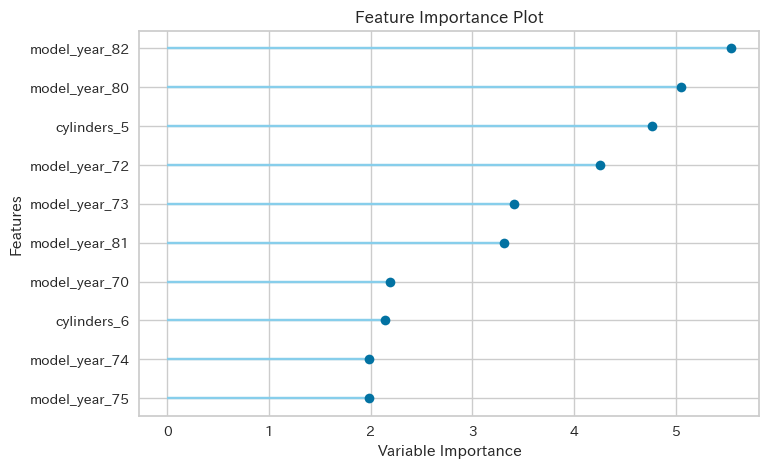

In [312]:
#plot_model関数を使い、各特徴量の重要度をプロットする

plot_model(tuned_br,plot='feature')  #各特徴量の重要度をプロット

'car name'は167種類もあるので分類が難しそうだが、重要度が高い  
diselはかなり走行距離が大きい。

### 本番モデルの作成

In [313]:
#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。

final_br = finalize_model(tuned_br) #最終的なモデル
print(final_br)

BayesianRidge(alpha_1=0.1, alpha_2=0.1, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.01, lambda_2=1e-06,
              lambda_init=None, n_iter=300, normalize=True, tol=0.001,
              verbose=False)


### 提出用のデータを作成  
テストデータを使用して、予測  
予測結果には、予測値を表す「Label」列が含まれる。

In [314]:
test_pred = predict_model(final_br,data=df_test_cy_ye)
test_pred.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0,0,0,0,0,0


,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,Label
0,1,6,145.0,76.0,3160.0,19.6,81,2,NaN,27.091476
1,2,6,250.0,98.0,3525.0,19.0,77,1,NaN,18.170331
2,4,4,119.0,92.0,2434.0,15.0,80,3,NaN,34.162229
3,5,6,258.0,110.0,2962.0,13.5,71,1,NaN,18.945577
4,6,4,97.0,88.0,2100.0,16.5,72,3,NaN,25.698452


In [315]:
test_df['y_pred'] = test_pred['Label']
test_df

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,y_pred
0,1,6,145.0,76.00,3160.0,19.6,81,2,NaN,27.091476
1,2,6,250.0,98.00,3525.0,19.0,77,1,NaN,18.170331
2,4,4,119.0,92.00,2434.0,15.0,80,3,NaN,34.162229
3,5,6,258.0,110.0,2962.0,13.5,71,1,NaN,18.945577
4,6,4,97.0,88.00,2100.0,16.5,72,3,NaN,25.698452
...,...,...,...,...,...,...,...,...,...,...
194,391,4,114.0,91.00,2582.0,14.0,73,2,NaN,23.932544
195,392,4,156.0,105.0,2800.0,14.4,80,1,NaN,30.136417
196,393,4,111.0,80.00,2155.0,14.8,77,1,NaN,27.092582
197,394,8,400.0,180.0,4220.0,11.1,77,1,NaN,14.455236


In [316]:
test_df[['id','y_pred']].to_csv('sample_submit_01.csv', index=False, header = False)

In [317]:
sample_submit_01 = pd.read_csv('sample_submit_01.csv')
sample_submit_01

,1,27.09147608545466
0,2,18.170331
1,4,34.162229
2,5,18.945577
3,6,25.698452
4,7,25.882686
...,...,...
193,391,23.932544
194,392,30.136417
195,393,27.092582
196,394,14.455236


データ提出  
テストデータ結果3.2374564

## 検証4  
'car name'をダミー変数化してAutoML

In [12]:
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)



test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name','mpg'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [319]:

clf = setup(data=df_train_cy_ye, 
            target="mpg",  #正解データを指定
            session_id=123  # 環境の初期化
           )

,Description,Value
0,session_id,123
1,Target,mpg
2,Original Data,"(199, 10)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(139, 143)"


In [320]:
#全てのモデルを訓練し、評価する。
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.3212,10.3740,3.1563,0.7899,0.1205,0.0950,0.0300
omp,Orthogonal Matching Pursuit,2.7514,13.4054,3.5622,0.7443,0.1433,0.1181,0.0150
et,Extra Trees Regressor,2.4784,15.4037,3.7288,0.7145,0.1331,0.0970,0.2150
ridge,Ridge Regression,2.7847,14.2937,3.6632,0.7123,0.1405,0.1147,0.0120
rf,Random Forest Regressor,2.6674,15.6246,3.7731,0.7007,0.1337,0.1062,0.2190
gbr,Gradient Boosting Regressor,2.6396,14.9329,3.7401,0.6917,0.1302,0.1055,0.0590
ada,AdaBoost Regressor,3.0105,17.2983,3.9959,0.6681,0.1452,0.1219,0.0880
xgboost,Extreme Gradient Boosting,2.9700,18.5028,4.1837,0.6191,0.1486,0.1206,0.1610
en,Elastic Net,3.5966,22.2611,4.6301,0.5561,0.1854,0.1484,0.0130
lasso,Lasso Regression,3.6017,22.3491,4.6402,0.5532,0.1840,0.1481,0.0150


今回signateの評価方法は「RMSE」(小さいほど良い)なので注目  
モデル「Extra Trees Regressor」において、RMSEが3.0707とまずまず

In [321]:
#最もスコアの良いモデルの概要を表示する。
print(best_model)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


### モデル作成

In [322]:
#models関数により、すべての使用可能な機械学習モデルを確認
#機械学習モデルの一覧
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


最も精度の良かったBayesianRidgeでモデルを作成する。

In [324]:
#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#勾配ブースティングのモデルを作成
br=create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8288,8.7817,2.9634,0.5777,0.1174,0.0880
1,2.3330,15.1045,3.8865,0.7010,0.1330,0.0868
2,2.7862,15.2847,3.9096,0.7769,0.1195,0.0938
3,2.9160,10.8097,3.2878,0.8721,0.1198,0.1168
4,1.7608,4.3162,2.0775,0.8884,0.0687,0.0641
5,1.6430,7.0230,2.6501,0.7950,0.0872,0.0677
6,2.2104,9.4606,3.0758,0.7621,0.2218,0.1359
7,2.2805,7.7083,2.7764,0.8569,0.1004,0.0910
8,2.0085,7.2518,2.6929,0.9082,0.1079,0.0895


In [325]:
print(br)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


#### ハイパーパラメータの調節

In [326]:
#tune_model関数を用いて、ハイパーパラメータを最適化する。

tuned_br = tune_model(br)  #ハイパーパラメータが自動で調整される。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8286,8.7829,2.9636,0.5777,0.1174,0.0880
1,2.3342,15.1123,3.8874,0.7008,0.1330,0.0869
2,2.7854,15.2837,3.9094,0.7769,0.1195,0.0937
3,2.9167,10.8135,3.2884,0.8720,0.1198,0.1168
4,1.7608,4.3100,2.0761,0.8886,0.0687,0.0641
5,1.6428,7.0229,2.6501,0.7950,0.0872,0.0677
6,2.2101,9.4597,3.0757,0.7621,0.2217,0.1359
7,2.2803,7.7060,2.7760,0.8570,0.1004,0.0910
8,2.0074,7.2482,2.6922,0.9082,0.1079,0.0895


ハイパーパラメータを調整済みの、モデルの概要を表示する。  
ハイパーパラメータを調節前の方が精度が良いので、ハイパーパラメータを調節前のパラメータを使う

In [327]:
print(tuned_br)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=0.05, lambda_2=0.0001, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


先ほどと比べるといくらかハイパーパラメータが変わっている。

### モデルを評価する

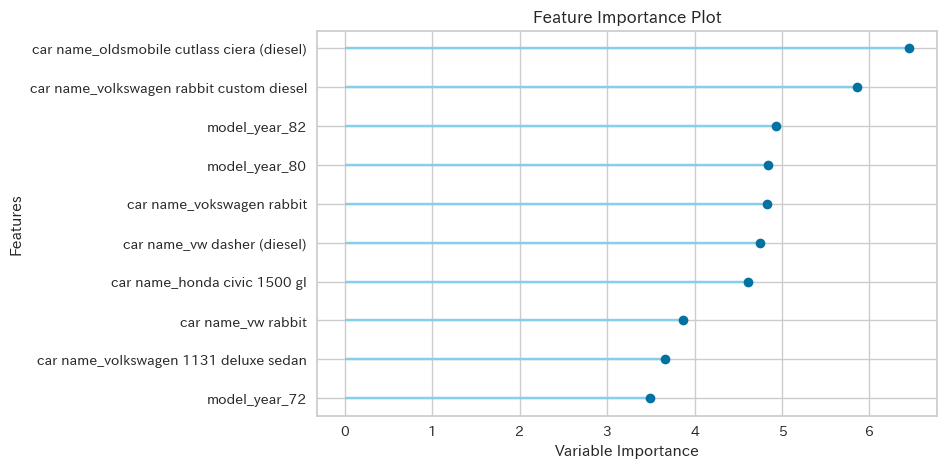

In [328]:
#plot_model関数を使い、各特徴量の重要度をプロットする

plot_model(tuned_br,plot='feature')  #各特徴量の重要度をプロット

'car name'は167種類もあるので分類が難しそうだが、重要度が高い  
diselはかなり走行距離が大きい。

### 本番モデルの作成

In [329]:
#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。

final_br = finalize_model(tuned_br) #最終的なモデル
print(final_br)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=0.05, lambda_2=0.0001, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


### 提出用のデータを作成  
テストデータを使用して、予測  
予測結果には、予測値を表す「Label」列が含まれる。

In [331]:
test_pred = predict_model(final_br,data=df_test_cy_ye)
test_pred.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0,0,0,0,0,0


,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,mpg,Label
0,1,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel,NaN,26.806581
1,2,6,250.0,98.0,3525.0,19.0,77,1,ford granada,NaN,18.725321
2,4,4,119.0,92.0,2434.0,15.0,80,3,datsun 510 hatchback,NaN,33.635278
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),NaN,19.614555
4,6,4,97.0,88.0,2100.0,16.5,72,3,toyota corolla 1600 (sw),NaN,26.274680


In [332]:
test_df['y_pred'] = test_pred['Label']
test_df

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,mpg,y_pred
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel,NaN,26.806581
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada,NaN,18.725321
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback,NaN,33.635278
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),NaN,19.614555
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw),NaN,26.274680
...,...,...,...,...,...,...,...,...,...,...,...
194,391,4,114.0,91.00,2582.0,14.0,73,2,audi 100ls,NaN,24.164022
195,392,4,156.0,105.0,2800.0,14.4,80,1,dodge colt,NaN,30.457079
196,393,4,111.0,80.00,2155.0,14.8,77,1,buick opel isuzu deluxe,NaN,27.617935
197,394,8,400.0,180.0,4220.0,11.1,77,1,pontiac grand prix lj,NaN,14.435242


In [333]:
test_df[['id','y_pred']].to_csv('sample_submit_02.csv', index=False, header = False)

In [338]:
sample_submit_02 = pd.read_csv('sample_submit_02.csv')
sample_submit_02.head()

,1,26.806581014809886
0,2,18.725321
1,4,33.635278
2,5,19.614555
3,6,26.274680
4,7,26.228334


データ提出  
テストデータ結果RMSE:2.8491178

## 検証5   
#### lightGBM(simple)

In [4]:
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})

#car nameを除く
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)


#testデータの読み込み
test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


In [5]:
#前処理

#df_train_cy_ye,df_test_cy_yeを結合する。
df = pd.concat([df_train_cy_ye, df_test_cy_ye], axis=0)

df.shape,train_df.shape,test_df.shape

((398, 9), (199, 9), (199, 8))

In [6]:
# 目的変数と説明変数の生成
train = df[:199]
test = df[199:]

x = train.drop('mpg', axis=1)
y = train['mpg']

x.shape, y.shape

((199, 8), (199,))

In [7]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [8]:
from sklearn.metrics import mean_squared_error

#ハイパーパラメータ調整なし
lgb_reg=lgb.LGBMRegressor()
lgb_reg.fit(x_train, y_train)

pred01=lgb_reg.predict(x_train)
pred02=lgb_reg.predict(x_test)

print('学習用：', np.sqrt(mean_squared_error(y_true=y_train, y_pred=pred01)))
print('検証用：', np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred02)))

学習用： 1.7582472154950126
検証用： 2.932735914664382


若干過学習気味だが、まずまずの精度

### ハイパーパラメータの調整のためにグリッドサーチ

In [ ]:
from sklearn.model_selection import GridSearchCV

lgb_reg=lgb.LGBMRegressor()

params={
    'max_depth':[i for i in range(1,5)],
    'num_leaves':[2**i for i in range(1,5)],
    'learning_rate':[0.05+0.01*i for i in range(1,10)]
}

grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=params,
    cv=10,
    scoring='neg_mean_absolute_error',
    verbose=10
)

grid.fit(x_train,y_train)

print('最適なハイパーパラメータ',grid.best_params_)

再度表記  
最適なハイパーパラメータ {'learning_rate': 0.060000000000000005, 'max_depth': 2, 'num_leaves': 4}

In [16]:
best_params_ = grid.best_params_
lgb_reg=lgb.LGBMRegressor(
    max_depth=best_params_['max_depth'],
    num_leaves=best_params_['num_leaves'],
    learning_rate=best_params_['learning_rate']
)

lgb_reg.fit(x_train,y_train)

pred_train=lgb_reg.predict(x_train)
pred_test=lgb_reg.predict(x_test)

#グリッドサーチmax_depth:3,num_leaves:4,learning_rate:0.07
print('学習用：',np.sqrt(mean_squared_error(y_train,pred_train)))
print('検証用：',np.sqrt(mean_squared_error(y_test,pred_test)))

学習用： 2.2724309928722954
検証用： 2.73907211881396


まずまずの精度！

特徴量重要度の確認

In [17]:
#特徴量の重要度を確認
importance = pd.DataFrame(lgb_reg.feature_importances_, index=x_train.columns, columns=['importance'])
importance.sort_values(by='importance',ascending=False)

,importance
model_year,72
acceleration,47
horsepower,46
weight,43
id,18
displacement,17
origin,11
cluster01,2
cylinders,1


これだけを見ると加速度とモデル年が大きな影響を与えていることがわかる。  
排気量と比べて、加速度が大きな影響を与えているのは少し不自然？  
そこで、教師無し学習からクラスタリングを用いてデータの性質を調べてみる。

一旦提出

In [18]:
# 目的変数と説明変数の生成
#test_df = test_df.drop('mpg', axis=1)
df_test_cy_ye.shape

(199, 8)

通常モデルの場合

In [ ]:
test_pred = pred_test=lgb_reg.predict(df_test_cy_ye)
print(len(test_pred))

In [357]:
test_pred[:50]

array([27.05238166, 17.59121183, 31.67845644, 18.18373631, 27.07873674,
       25.33891902, 14.93466128, 19.71826227, 22.2325989 , 20.0190224 ,
       13.54465458, 29.41567298, 13.54465458, 35.29467365, 35.3538977 ,
       14.75258991, 25.11562432, 23.18654216, 13.49463753, 29.48101698,
       25.73660982, 37.44002172, 16.21709731, 13.54465458, 15.8807051 ,
       13.54465458, 13.93518068, 21.20580282, 30.623104  , 29.4614451 ,
       34.22574589, 19.5176875 , 37.11775403, 13.54465458, 19.5176875 ,
       31.82124191, 33.42602901, 19.76004109, 27.86074056, 37.13941436,
       13.78651155, 28.3980485 , 21.55170662, 29.72287396, 21.75155185,
       37.44002172, 36.38957208, 19.97313123, 23.2434884 , 26.41553659])

In [358]:
sub = test.copy()
sub['mpg'] = test_pred
sub.head(5)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,1,6,145.0,76.0,3160.0,19.6,81,2,27.052382
1,2,6,250.0,98.0,3525.0,19.0,77,1,17.591212
2,4,4,119.0,92.0,2434.0,15.0,80,3,31.678456
3,5,6,258.0,110.0,2962.0,13.5,71,1,18.183736
4,6,4,97.0,88.0,2100.0,16.5,72,3,27.078737


In [359]:
# 提出ファイル
sub[['id','mpg']].to_csv('sample_submit_03.csv', index=False, header = False)

In [360]:
sample_submit_03 = pd.read_csv('sample_submit_03.csv')
sample_submit_03.head(5)

,1,27.052381658899964
0,2,17.591212
1,4,31.678456
2,5,18.183736
3,6,27.078737
4,7,25.338919


テストデータ提出  
評価(RMSE):2.8665029

### 教師無し学習からクラスタリング  
教師なし学習からクラスタリングを用いて、モデルを作成する。

### kmeans法  

cluster02を変数に加えて、グリッドサーチしてみる。

In [63]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

df_train_cy_ye['cluster02'] = cluster02['cluster02']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']


In [22]:
#df_train_cy_yeにcluster01変数を加える。
#df_train_cy_ye['cluster01'] = cluster01['cluster01']
df_train_cy_ye.head(3)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,cluster01
0,0,4,135.0,84.0,2525.0,16.0,82,1,29.0,0
1,3,4,89.0,71.0,1925.0,14.0,79,2,31.9,0
2,9,6,156.0,108.0,2930.0,15.5,76,3,19.0,1


In [64]:
#前処理

#df_train_cy_ye,df_test_cy_yeを結合する。
df = pd.concat([df_train_cy_ye, df_test_cy_ye], axis=0)

df.shape,train_df.shape,test_df.shape

((398, 10), (199, 9), (199, 8))

In [65]:
# 目的変数と説明変数の生成
train = df[:199]
test = df[199:]

x = train.drop('mpg', axis=1)
y = train['mpg']

x.shape, y.shape

((199, 9), (199,))

In [66]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [ ]:
from sklearn.model_selection import GridSearchCV

lgb_reg=lgb.LGBMRegressor()

params={
    'max_depth':[i for i in range(1,5)],
    'num_leaves':[2**i for i in range(1,5)],
    'learning_rate':[0.05+0.01*i for i in range(1,10)]
}

grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=params,
    cv=10,
    scoring='neg_mean_absolute_error',
    verbose=10
)

grid.fit(x_train,y_train)

print('最適なハイパーパラメータ',grid.best_params_)

再度表記  
最適なハイパーパラメータ {'learning_rate': 0.060000000000000005, 'max_depth': 2, 'num_leaves': 4}

In [68]:
best_params_ = grid.best_params_
lgb_reg=lgb.LGBMRegressor(
    max_depth=best_params_['max_depth'],
    num_leaves=best_params_['num_leaves'],
    learning_rate=best_params_['learning_rate']
)

lgb_reg.fit(x_train,y_train)

pred_train=lgb_reg.predict(x_train)
pred_test=lgb_reg.predict(x_test)

#グリッドサーチmax_depth:3,num_leaves:4,learning_rate:0.07
print('学習用：',np.sqrt(mean_squared_error(y_train,pred_train)))
print('検証用：',np.sqrt(mean_squared_error(y_test,pred_test)))

学習用： 2.2724309928722954
検証用： 2.7411701863912756


学習用： 2.2724309928722954  
検証用： 2.7411701863912756

まずまずの精度！ 
少し精度よくなっている。

特徴量重要度の確認

In [69]:
#特徴量の重要度を確認
importance = pd.DataFrame(lgb_reg.feature_importances_, index=x_train.columns, columns=['importance'])
importance.sort_values(by='importance',ascending=False)

,importance
model_year,72
acceleration,47
horsepower,46
weight,43
id,18
displacement,17
origin,11
cluster02,2
cylinders,1


cluster02はほとんど影響していないが、精度は向上した。

### AdaBoost

In [70]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

model = AdaBoostRegressor(n_estimators=1000,
                         random_state = 0,
                         base_estimator = DecisionTreeRegressor(random_state = 0,
                                                               max_depth=6))

model.fit(x_train,y_train)#学習


print(model.score(x_test,y_test))

0.8632648423851048


### lightGBM + optuna

In [ ]:
import optuna.integration.lightgbm as lgbo

train=lgb.Dataset(x_train, y_train)
test=lgb.Dataset(x_test, y_test)

params = {
    "objective": "regression_l2",
    "metric": "mean_squared_error",
    'n_estimators': 100000, 
    'verbosity':-1,
    'n_jobs':-1
}

lgbo1 = lgbo.train(params, train, 
                    valid_sets=test,
                    verbose_eval=False,
                    early_stopping_rounds=1000,
                    )


print('学習用：　',mean_squared_error(y_pred=lgbo1.predict(x_train),y_true=y_train, squared=False))
print('検証用：　',mean_squared_error(y_pred=lgbo1.predict(x_test),y_true=y_test,squared=False))

精度結構よい！  
学習用：　 2.39985012086571  
検証用：　 2.488770032435394

### 提出用データを得る。

In [72]:
df_test_cy_ye.shape

(199, 9)

In [74]:
#df_test_cy_yeのデータを整える
df_test_cy_ye = df_test_cy_ye.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','cluster_test02']) 
df_test_cy_ye.dtypes

id                  int64
cylinders           int64
displacement      float64
horsepower        float64
weight            float64
acceleration      float64
model_year          int64
origin              int64
cluster_test02    float64
dtype: object

In [75]:
y_pred=lgbo1.predict(df_test_cy_ye)

In [76]:
print(len(y_pred))

199


In [77]:
y_pred[:50]

array([27.43372248, 17.91770624, 31.38033551, 18.00666939, 27.25543386,
       25.95022291, 14.33344483, 19.86791943, 23.98316337, 21.13783013,
       13.57856966, 28.51102916, 13.57856966, 35.088574  , 35.18885444,
       14.70719401, 25.13038261, 24.00058792, 13.93353772, 29.79256727,
       26.67568129, 36.73806645, 15.82922306, 13.57856966, 16.29857591,
       13.57856966, 13.41584655, 20.39715796, 30.17001156, 30.28181291,
       34.19307201, 18.69504827, 37.14140816, 13.57856966, 18.69504827,
       31.26562766, 33.11331992, 19.37105168, 26.27576049, 36.76376265,
       13.57856966, 29.13718784, 21.35250152, 29.58375481, 21.23326119,
       37.45819905, 35.39085083, 18.87087408, 24.06777186, 25.3610125 ])

In [78]:
sub = test_df.copy()
sub['mpg'] = y_pred
sub.head(5)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,1,6,145.0,76.00,3160.0,19.6,81,2,27.433722
1,2,6,250.0,98.00,3525.0,19.0,77,1,17.917706
2,4,4,119.0,92.00,2434.0,15.0,80,3,31.380336
3,5,6,258.0,110.0,2962.0,13.5,71,1,18.006669
4,6,4,97.0,88.00,2100.0,16.5,72,3,27.255434


In [79]:
# 提出ファイル
sub[['id','mpg']].to_csv('sample_submit_11.csv', index=False, header = False)

In [80]:
sample_submit_11 = pd.read_csv('sample_submit_11.csv')
sample_submit_11.head(5)

,1,27.433722480110166
0,2,17.917706
1,4,31.380336
2,5,18.006669
3,6,27.255434
4,7,25.950223


cluster01を加えるバージョンは提出後の精度は2.9228671だった。  
cluster04を加えるバージョンは2.8747852で精度向上
精度は上がったので、AutoMLのモデルの説明変数として加える価値あり！  

## 検証6

kmeans法で得られたクラスタとwards法で得られたクラスタを説明変数に加えて、AutoMLにかけてみる。

'car name'をダミー変数化してAutoML

In [227]:
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)



test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car name'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)


cluster01,cluster02,cluster04をtrainデータに加える。

In [208]:
df_train_cy_ye['cluster01'] = cluster01
df_train_cy_ye['cluster02'] = cluster02
df_train_cy_ye['cluster04'] = cluster04
df_train_cy_ye.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,mpg,cluster01,cluster02,cluster04
0,0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se,29.0,0,1,1
1,3,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom,31.9,0,1,1
2,9,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii,19.0,1,2,2
3,11,4,90.0,75.0,2125.0,14.5,74,1,dodge colt,28.0,0,1,1
4,13,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel,37.7,0,1,1


In [209]:

clf = setup(data=df_train_cy_ye, 
            target="mpg",  #正解データを指定
            session_id=123  # 環境の初期化
           )

,Description,Value
0,session_id,123
1,Target,mpg
2,Original Data,"(199, 13)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(139, 146)"


In [149]:
#全てのモデルを訓練し、評価する。
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,2.2798,10.2678,3.1286,0.7933,0.1181,0.0929,0.0130
br,Bayesian Ridge,2.3053,10.3050,3.1417,0.7925,0.1198,0.0942,0.0350
et,Extra Trees Regressor,2.3322,12.9748,3.4421,0.7547,0.1230,0.0925,0.1730
omp,Orthogonal Matching Pursuit,2.7514,13.4054,3.5622,0.7443,0.1433,0.1181,0.0110
rf,Random Forest Regressor,2.6439,15.3056,3.7317,0.7095,0.1323,0.1053,0.1900
gbr,Gradient Boosting Regressor,2.6428,14.6770,3.7106,0.6971,0.1288,0.1052,0.0570
ada,AdaBoost Regressor,3.0647,17.6614,4.0658,0.6552,0.1481,0.1251,0.0600
en,Elastic Net,3.5966,22.2611,4.6301,0.5561,0.1854,0.1484,0.0130
lasso,Lasso Regression,3.6017,22.3491,4.6402,0.5532,0.1840,0.1481,0.0140
lightgbm,Light Gradient Boosting Machine,3.5777,24.5175,4.7989,0.5339,0.1734,0.1440,0.0310


今回signateの評価方法は「RMSE」(小さいほど良い)なので注目  
モデル「Extra Trees Regressor」において、RMSEが3.0707とまずまず

In [210]:
#最もスコアの良いモデルの概要を表示する。
print(best_model)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


### モデル作成

In [211]:
#models関数により、すべての使用可能な機械学習モデルを確認
#機械学習モデルの一覧
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


最も精度の良かったBayesianRidgeでモデルを作成する。

In [214]:
#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#勾配ブースティングのモデルを作成
ridge=create_model('ridge')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6988,7.9342,2.8168,0.6185,0.1094,0.0807
1,2.6553,17.0349,4.1273,0.6627,0.1421,0.0990
2,2.7127,15.8236,3.9779,0.7691,0.1171,0.0873
3,2.9503,11.4365,3.3818,0.8646,0.1228,0.1176
4,1.6807,3.8494,1.9620,0.9005,0.0660,0.0616
5,1.6450,6.7587,2.5998,0.8027,0.0843,0.0670
6,2.1163,8.5069,2.9167,0.7861,0.2098,0.1313
7,2.1333,6.2932,2.5086,0.8832,0.0905,0.0845
8,1.8310,6.4583,2.5413,0.9182,0.0918,0.0784


In [215]:
print(ridge)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


#### ハイパーパラメータの調節

In [216]:
#tune_model関数を用いて、ハイパーパラメータを最適化する。

tuned_ridge = tune_model(ridge)  #ハイパーパラメータが自動で調整される。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1106,9.6322,3.1036,0.5368,0.1190,0.1033
1,2.9287,21.8177,4.6709,0.5680,0.1634,0.1100
2,2.4293,16.0300,4.0037,0.7661,0.1159,0.0765
3,3.2648,16.0837,4.0105,0.8096,0.1469,0.1306
4,1.5641,3.6589,1.9128,0.9054,0.0700,0.0617
5,1.9786,6.9849,2.6429,0.7961,0.0999,0.0884
6,2.4707,10.5017,3.2406,0.7359,0.2529,0.1511
7,2.2034,8.3723,2.8935,0.8446,0.1008,0.0829
8,1.7177,7.7338,2.7810,0.9021,0.0863,0.0671


ハイパーパラメータを調整済みの、モデルの概要を表示する。  
ハイパーパラメータを調節前の方が精度が良いので、ハイパーパラメータを調節前のパラメータを使う

In [217]:
print(ridge)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


先ほどと比べるといくらかハイパーパラメータが変わっている。

### モデルを評価する

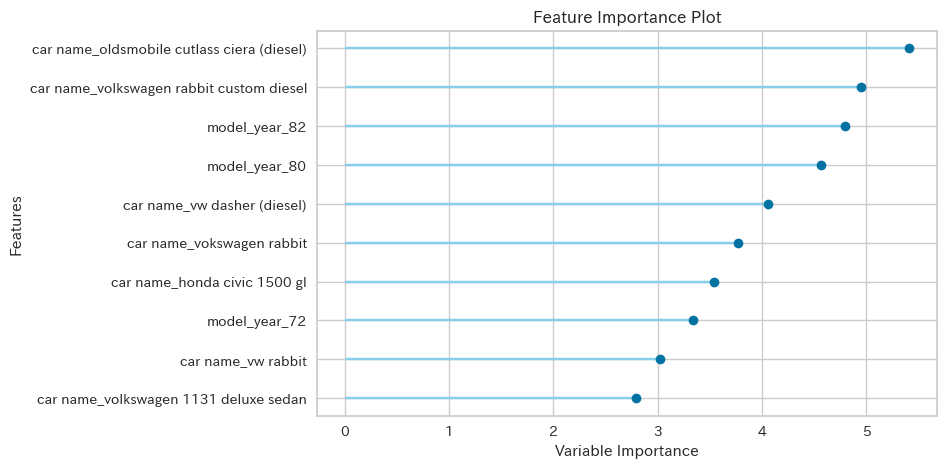

In [218]:
#plot_model関数を使い、各特徴量の重要度をプロットする

plot_model(ridge,plot='feature')  #各特徴量の重要度をプロット

'car name'は167種類もあるので分類が難しそうだが、重要度が高い  
diselはかなり走行距離が大きい。

### 本番モデルの作成

In [219]:
#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。

final_ridge = finalize_model(ridge) #最終的なモデル
print(final_ridge)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)


### 提出用のデータを作成  
テストデータを使用して、予測  
予測結果には、予測値を表す「Label」列が含まれる。

In [222]:
cluster_test01 = pd.read_csv('cluster_test01.csv')
cluster_test01.head()

,Unnamed: 0,cluster_test01
0,0,0
1,1,0
2,2,2
3,3,0
4,4,2


In [223]:
cluster_test02 = pd.read_csv('cluster_test02.csv')
cluster_test02.head(7)

,Unnamed: 0,cluster_test02
0,0,0
1,1,2
2,2,0
3,3,2
4,4,0
5,5,0
6,6,1


In [224]:
cluster_test02.head()

,Unnamed: 0,cluster_test02
0,0,0
1,1,2
2,2,0
3,3,2
4,4,0


In [225]:
cluster_test04 = pd.read_csv('cluster_test04.csv')
cluster_test04.head()

,Unnamed: 0,cluster_test04
0,0,1
1,1,2
2,2,1
3,3,2
4,4,1


In [228]:
df_test_cy_ye.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name
0,1,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel
1,2,6,250.0,98.0,3525.0,19.0,77,1,ford granada
2,4,4,119.0,92.0,2434.0,15.0,80,3,datsun 510 hatchback
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw)
4,6,4,97.0,88.0,2100.0,16.5,72,3,toyota corolla 1600 (sw)


In [229]:
df_test_cy_ye['cluster01'] = cluster_test01['cluster_test01']
df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']
df_test_cy_ye['cluster04'] = cluster_test04['cluster_test04']
df_test_cy_ye.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,cluster01,cluster02,cluster04
0,1,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel,0,0,1
1,2,6,250.0,98.0,3525.0,19.0,77,1,ford granada,0,2,2
2,4,4,119.0,92.0,2434.0,15.0,80,3,datsun 510 hatchback,2,0,1
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),0,2,2
4,6,4,97.0,88.0,2100.0,16.5,72,3,toyota corolla 1600 (sw),2,0,1


In [230]:
test_pred = predict_model(final_ridge,data=df_test_cy_ye)
test_pred.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,cluster01,cluster02,cluster04,Label
0,1,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel,0,0,1,29.542816
1,2,6,250.0,98.0,3525.0,19.0,77,1,ford granada,0,2,2,19.937988
2,4,4,119.0,92.0,2434.0,15.0,80,3,datsun 510 hatchback,2,0,1,31.719285
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),0,2,2,20.593418
4,6,4,97.0,88.0,2100.0,16.5,72,3,toyota corolla 1600 (sw),2,0,1,23.638529


In [231]:
test_df['y_pred'] = test_pred['Label']
test_df

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,y_pred
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel,29.542816
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada,19.937988
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback,31.719285
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),20.593418
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw),23.638529
...,...,...,...,...,...,...,...,...,...,...
194,391,4,114.0,91.00,2582.0,14.0,73,2,audi 100ls,22.218540
195,392,4,156.0,105.0,2800.0,14.4,80,1,dodge colt,29.231817
196,393,4,111.0,80.00,2155.0,14.8,77,1,buick opel isuzu deluxe,25.677245
197,394,8,400.0,180.0,4220.0,11.1,77,1,pontiac grand prix lj,16.579954


In [232]:
test_df[['id','y_pred']].to_csv('sample_submit_06.csv', index=False, header = False)

In [233]:
sample_submit_06 = pd.read_csv('sample_submit_06.csv')
sample_submit_06.head()

,1,29.542815850315858
0,2,19.937988
1,4,31.719285
2,5,20.593418
3,6,23.638529
4,7,23.707623


データ提出  
テストデータ結果RMSE:3.737

clusterデータを入れて、予測する。

## 検証7   
#### lightGBM(simple)でcluster02を加えてみる。

In [41]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

df_train_cy_ye['cluster02'] = cluster02['cluster02']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['id','cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']


In [42]:
#前処理

#df_train_cy_ye,df_test_cy_yeを結合する。
df = pd.concat([df_train_cy_ye, df_test_cy_ye], axis=0)

df.shape,train_df.shape,test_df.shape

((398, 10), (199, 9), (199, 8))

In [43]:
# 目的変数と説明変数の生成
train = df[:199]
test = df[199:]

x = train.drop('mpg', axis=1)
y = train['mpg']

x.shape, y.shape

((199, 9), (199,))

In [44]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [45]:
from sklearn.metrics import mean_squared_error

#ハイパーパラメータ調整なし
lgb_reg=lgb.LGBMRegressor()
lgb_reg.fit(x_train, y_train)

pred01=lgb_reg.predict(x_train)
pred02=lgb_reg.predict(x_test)

print('学習用：', np.sqrt(mean_squared_error(y_true=y_train, y_pred=pred01)))
print('検証用：', np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred02)))

学習用： 1.7444123384977657
検証用： 2.941519205303891


若干過学習気味だが、まずまずの精度

### ハイパーパラメータの調整のためにグリッドサーチ

In [ ]:
from sklearn.model_selection import GridSearchCV

lgb_reg=lgb.LGBMRegressor()

params={
    'max_depth':[i for i in range(1,5)],
    'num_leaves':[2**i for i in range(1,5)],
    'learning_rate':[0.05+0.01*i for i in range(1,10)]
}

grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=params,
    cv=10,
    scoring='neg_mean_absolute_error',
    verbose=10
)

grid.fit(x_train,y_train)

print('最適なハイパーパラメータ',grid.best_params_)

再度表記  
最適なハイパーパラメータ {'learning_rate': 0.060000000000000005, 'max_depth': 2, 'num_leaves': 4}

In [62]:
best_params_ = grid.best_params_
lgb_reg=lgb.LGBMRegressor(
    max_depth=best_params_['max_depth'],
    num_leaves=best_params_['num_leaves'],
    learning_rate=best_params_['learning_rate']
)

lgb_reg.fit(x_train,y_train)

pred_train=lgb_reg.predict(x_train)
pred_test=lgb_reg.predict(x_test)

#グリッドサーチmax_depth:3,num_leaves:4,learning_rate:0.07
print('学習用：',np.sqrt(mean_squared_error(y_train,pred_train)))
print('検証用：',np.sqrt(mean_squared_error(y_test,pred_test)))

学習用： 2.2724309928722954
検証用： 2.7411701863912756


まずまずの精度！

特徴量重要度の確認

In [50]:
#特徴量の重要度を確認
importance = pd.DataFrame(lgb_reg.feature_importances_, index=x_train.columns, columns=['importance'])
importance.sort_values(by='importance',ascending=False)

,importance
model_year,72
acceleration,47
horsepower,46
weight,43
id,18
displacement,17
origin,11
cluster02,2
cylinders,1


これだけを見ると加速度とモデル年が大きな影響を与えていることがわかる。  
排気量と比べて、加速度が大きな影響を与えているのは少し不自然？  
そこで、教師無し学習からクラスタリングを用いてデータの性質を調べてみる。

一旦提出

In [51]:
# 目的変数と説明変数の生成
#test_df = test_df.drop('mpg', axis=1)
df_test_cy_ye.shape

(199, 9)

通常モデルの場合

In [52]:
test_pred = pred_test=lgb_reg.predict(df_test_cy_ye)
print(len(test_pred))

199


In [53]:
test_pred[:50]

array([27.01282558, 17.61552358, 31.67479883, 18.15648822, 27.1260035 ,
       25.40544812, 15.01230685, 19.77732131, 22.25353009, 20.04474749,
       13.58328941, 29.44210002, 13.58328941, 35.29101604, 35.38545736,
       14.84137474, 25.10304063, 23.25179902, 13.46333692, 29.52469383,
       25.78387658, 37.41771544, 16.22002801, 13.58328941, 15.96733821,
       13.58328941, 14.02181078, 21.2291176 , 30.57805207, 29.5583784 ,
       34.26942273, 19.49960797, 37.13684206, 13.58328941, 19.49960797,
       31.78168583, 33.39859012, 19.78097228, 27.91924795, 37.1973126 ,
       13.78319321, 28.48289447, 21.53618049, 29.72459763, 21.69701499,
       37.41771544, 36.48174028, 19.95210624, 23.22246642, 26.36099974])

In [54]:
sub = test.copy()
sub['mpg'] = test_pred
sub.head(5)

,id,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,cluster02
0,1,6,145.0,76.0,3160.0,19.6,81,2,27.012826,4
1,2,6,250.0,98.0,3525.0,19.0,77,1,17.615524,5
2,4,4,119.0,92.0,2434.0,15.0,80,3,31.674799,4
3,5,6,258.0,110.0,2962.0,13.5,71,1,18.156488,5
4,6,4,97.0,88.0,2100.0,16.5,72,3,27.126003,4


In [56]:
# 提出ファイル
sub[['id','mpg']].to_csv('sample_submit_10.csv', index=False, header = False)

In [57]:
sample_submit_10 = pd.read_csv('sample_submit_10.csv')
sample_submit_10.head(5)

,1,27.012825579473812
0,2,17.615524
1,4,31.674799
2,5,18.156488
3,6,27.126003
4,7,25.405448


テストデータ提出  
評価(RMSE):2.8511530。

cluster02を加えたことで、0.015上がった。  
教師なし学習をして、テストデータと訓練データに差がないクラスターを採用することで精度を向上できた。

## 検証8  
検証3のsimplelightgbmとAdoboostを改めて試す。cluster02を変数に加えて、グリッドサーチしてみる。

In [3]:
#前処理
train_df = pd.read_table('train.tsv')
train_df = train_df.rename(columns={'model year':'model_year'})
train_df = train_df.reindex(columns=['cylinders','displacement','horsepower','weight','acceleration','model_year','origin','mpg'])

#horsepowerの?を取り除く
df_train_nn = copy.copy(train_df.query('horsepower != "?"'))
df_train_nn['horsepower'] = df_train_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_train_nn.groupby(['cylinders','model_year']).mean()
df_train_cy_ye = copy.copy(train_df)
df_train_cy_ye.loc[df_train_cy_ye['horsepower']=='?','horsepower'] = train_df[train_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_train_cy_ye.horsepower = df_train_cy_ye.horsepower.astype(float)

cluster02 = pd.read_csv('cluster02.csv')

#cluster2の0を3に
cluster02 = cluster02.replace(0,3)

#cluster_test02の1を4に
cluster02 = cluster02.replace(1,4)

#cluster_test02の2を5に
cluster02 = cluster02.replace(2,5)
cluster02.head()

#df_train_cy_ye['cluster01'] = cluster01['cluster01']
df_train_cy_ye['cluster02'] = cluster02['cluster02']
#df_train_cy_ye['cluster04'] = cluster04['cluster04']
df_train_cy_ye.head()


test_df = pd.read_table('test.tsv')
test_df = test_df.rename(columns={'model year':'model_year'})
test_df = test_df.reindex(columns=['cylinders','displacement','horsepower','weight','acceleration','model_year','origin'])

#horsepowerの?を取り除く
df_test_nn = copy.copy(test_df.query('horsepower != "?"'))
df_test_nn['horsepower'] = df_test_nn['horsepower'].astype(float)

#'horsepower'をoriginとシリンダーでグループ化した後のグループ内で平均をとり埋める。
mean_group_cy_ye = df_test_nn.groupby(['cylinders','model_year']).mean()
df_test_cy_ye = copy.copy(test_df)
df_test_cy_ye.loc[df_test_cy_ye['horsepower']=='?','horsepower'] = test_df[test_df['horsepower']=='?'].apply(lambda x: mean_group_cy_ye.loc[x.cylinders,x.model_year]['horsepower'], axis=1)
df_test_cy_ye.horsepower = df_test_cy_ye.horsepower.astype(float)

cluster_test02 = pd.read_csv('cluster_test02.csv')

#cluster_test02の1を3に
cluster_test02 = cluster_test02.replace(1,3)

#cluster_test02の2を5に
cluster_test02 = cluster_test02.replace(2,5)

#cluster_test02の0を4に
cluster_test02 = cluster_test02.replace(0,4)

#df_test_cy_ye['cluster01'] = cluster_test01['cluster_test01']
df_test_cy_ye['cluster02'] = cluster_test02['cluster_test02']
#df_test_cy_ye['cluster04'] = cluster_test04['cluster_test04']

In [4]:
df_train_cy_ye.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,cluster02
0,4,135.0,84.0,2525.0,16.0,82,1,29.0,4
1,4,89.0,71.0,1925.0,14.0,79,2,31.9,4
2,6,156.0,108.0,2930.0,15.5,76,3,19.0,5
3,4,90.0,75.0,2125.0,14.5,74,1,28.0,4
4,4,89.0,62.0,2050.0,17.3,81,3,37.7,4


In [5]:
#前処理

#df_train_cy_ye,df_test_cy_yeを結合する。
df = pd.concat([df_train_cy_ye, df_test_cy_ye], axis=0)

df.shape,train_df.shape,test_df.shape

((398, 9), (199, 8), (199, 7))

In [6]:
# 目的変数と説明変数の生成
train = df[:199]
test = df[199:]

x = train.drop('mpg', axis=1)
y = train['mpg']

x.shape, y.shape

((199, 8), (199,))

In [7]:
#学習・テストデータへの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle = True)

In [ ]:
from sklearn.model_selection import GridSearchCV

lgb_reg=lgb.LGBMRegressor()

params={
    'max_depth':[i for i in range(1,5)],
    'num_leaves':[2**i for i in range(1,5)],
    'learning_rate':[0.05+0.01*i for i in range(1,10)]
}

grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=params,
    cv=10,
    scoring='neg_mean_absolute_error',
    verbose=10
)

grid.fit(x_train,y_train)

print('最適なハイパーパラメータ',grid.best_params_)

再度表記  
最適なハイパーパラメータ {'learning_rate': 0.09, 'max_depth': 2, 'num_leaves': 4}

In [12]:
best_params_ = grid.best_params_
lgb_reg=lgb.LGBMRegressor(
    max_depth=best_params_['max_depth'],
    num_leaves=best_params_['num_leaves'],
    learning_rate=best_params_['learning_rate']
)

lgb_reg.fit(x_train,y_train)

pred_train=lgb_reg.predict(x_train)
pred_test=lgb_reg.predict(x_test)

#グリッドサーチmax_depth:3,num_leaves:4,learning_rate:0.07
print('学習用：',np.sqrt(mean_squared_error(y_train,pred_train)))
print('検証用：',np.sqrt(mean_squared_error(y_test,pred_test)))

学習用： 2.194397781059458
検証用： 2.6761192225496204


学習用： 2.194397781059458  
検証用： 2.6761192225496204

少し過学習気味だが
まずまずの精度！ 
少し精度よくなっている。

特徴量重要度の確認

In [13]:
#特徴量の重要度を確認
importance = pd.DataFrame(lgb_reg.feature_importances_, index=x_train.columns, columns=['importance'])
importance.sort_values(by='importance',ascending=False)

,importance
model_year,64
acceleration,60
horsepower,50
weight,39
displacement,23
origin,8
cluster02,8
cylinders,1


cluster02はほとんど影響していない。

### AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

model = AdaBoostRegressor(n_estimators=1000,
                         random_state = 0,
                         base_estimator = DecisionTreeRegressor(random_state = 0,
                                                               max_depth=6))

model.fit(x_train,y_train)#学習


print(model.score(x_test,y_test))

0.8501332550886144


### lightGBM + optuna

In [15]:
import optuna

In [16]:
import optuna.integration.lightgbm as lgbo

train=lgb.Dataset(x_train, y_train)
test=lgb.Dataset(x_test, y_test)

params = {
    "objective": "regression_l2",
    "metric": "mean_squared_error",
    'n_estimators': 100000, 
    'verbosity':-1,
    'n_jobs':-1
}

lgbo1 = lgbo.train(params, train, 
                    valid_sets=test,
                    verbose_eval=False,
                    early_stopping_rounds=1000,
                    )


print('学習用：　',mean_squared_error(y_pred=lgbo1.predict(x_train),y_true=y_train, squared=False))
print('検証用：　',mean_squared_error(y_pred=lgbo1.predict(x_test),y_true=y_test,squared=False))

[I 2022-11-28 14:54:46,086] A new study created in memory with name: no-name-c20a1f66-eb5a-4e61-b6cd-f1048cc287eb
min_data_in_leaf, val_score: 5.449687: 100%|##########| 5/5 [00:01<00:00,  3.34it/s]

学習用：　 2.335201225219402
検証用：　 2.334456298214034


精度結構よい！  
学習用：　 2.335201225219402  
検証用：　 2.334456298214034

In [17]:
y_pred=lgbo1.predict(df_test_cy_ye)

In [18]:
print(len(y_pred))

199


In [19]:
y_pred[:50]

array([26.39043444, 18.08215353, 31.96736956, 18.71764502, 26.7449095 ,
       25.22954235, 15.31029387, 19.43093111, 24.34181051, 21.62564234,
       13.99205293, 29.00742066, 13.99205293, 35.16889767, 34.65232572,
       15.37192505, 24.07587653, 23.38111539, 14.22011709, 30.41003594,
       26.20670867, 37.73569999, 16.06227198, 13.99205293, 17.06876768,
       13.99205293, 14.26732182, 21.10185293, 28.74476487, 30.08514917,
       34.37169174, 19.22979262, 36.50245346, 13.99205293, 18.97854205,
       29.37055554, 33.3972579 , 19.27170461, 27.84758867, 36.71001882,
       13.99205293, 29.01863064, 21.55152588, 30.28482758, 21.37321324,
       36.738928  , 35.67127086, 18.79629505, 24.91785071, 24.48995222])

In [20]:
test_df = pd.read_table('test.tsv')

In [21]:
sub = test_df.copy()
sub['mpg'] = y_pred
sub.head(5)

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel,26.390434
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada,18.082154
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback,31.967370
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw),18.717645
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw),26.744909


In [22]:
# 提出ファイル
sub[['id','mpg']].to_csv('sample_submit_12.csv', index=False, header = False)

In [23]:
sample_submit_08 = pd.read_csv('sample_submit_12.csv')
sample_submit_08.head(5)

,1,26.39043444498794
0,2,18.082154
1,4,31.967370
2,5,18.717645
3,6,26.744909
4,7,25.229542


提出精度  
2.7665386  
かなり良い精度が出た